<b> Part 1: Getting Started </b><br>

First, we write some starter code to output the information extracted from BGP updates. We extract a stream of updates using pybgpstream and filter for specific time periods, record types and collectors to narrow the stream. Each time a valid update from an AS is read, we print the update with all its fields, which includes the AS path of the update. 

In [2]:
import pybgpstream

# Create a new BPPStream instance for a 1 second window of time 
one_sec_stream = pybgpstream.BGPStream(
   from_time="2017-07-07 00:00:00", until_time ="2017-07-07 00:00:01 UTC",
   collectors=["route-views.sg", "route-views.eqix"],
   record_type="updates"
)

# Print BGP updates from stream 
for elem in one_sec_stream:
    print(elem)
    

update|A|1499385600.000000|routeviews|route-views.eqix|None|None|6939|206.126.236.37|91.192.240.0/22|206.126.236.37|6939 29632 31560||None|None
update|A|1499385600.000000|routeviews|route-views.eqix|None|None|11039|206.126.236.172|91.192.240.0/22|206.126.236.172|11039 6461 1299 29632 31560|6461:5997|None|None
update|A|1499385600.000000|routeviews|route-views.eqix|None|None|11039|206.126.236.172|91.192.240.0/22|206.126.236.172|11039 4901 11164 6939 12389 29076 197498 29632 31560||None|None
update|A|1499385600.000000|routeviews|route-views.eqix|None|None|11039|2001:504:0:2:0:1:1039:1|2804:2478::/32|2001:504:0:2::6939:1|11039 6939 53180 264224||None|None
update|W|1499385600.000000|routeviews|route-views.eqix|None|None|11039|206.126.236.172|186.250.114.0/24|None|None|None|None|None
update|A|1499385600.000000|routeviews|route-views.sg|None|None|38880|2001:de8:4::3:8880:1|2804:14c:da86::/48|2001:de8:4::6939:1|38880 6939 3356 4230 28573||None|None
update|A|1499385600.000000|routeviews|route-v

<b> Part 2: Training Our Code </b><br> 

In order to detect BGP Hijacks, we need to establish the true origins of prefixes. We do this by training our code on updates from BGPStream to build a global view of the network. 

We use the __[NetworkX](https://networkx.org)__  package to generate `as_graph`, a simple undirected graph of the network of ASes with no loops or self-edges. We also define a dictionary of dictionaries, `adr_dct`, to maintain prefixes and keep track of their true origins. 

In [3]:
import networkx as nx
import operator
from itertools import groupby
from collections import Counter

# init graph
as_graph = nx.Graph()

# init prefix dictionary
adr_dict = {}

START_TIME = "2017-07-07 00:00:00"
END_TIME = "2017-07-07 01:00:00 UTC"

# Create a new BPPStream instance for training data stream
stream = pybgpstream.BGPStream(
   from_time=START_TIME, until_time=END_TIME,
   collectors=["route-views.sg", "route-views.eqix"],
   record_type="updates"
)
stream.set_data_interface_option("broker", "cache-dir", "/home/mgumilang/.cache/")

Important fields to extract from each BGPStream update:
-  `peer`: the AS that announced the update 
-  `AS-path`: the AS-path from the peer to the origin of the prefix 
-  `prefix`: the IP address of the prefix announced by the origin 

We use the AS-path field to add edges between AS nodes and build the network graph. We also use these fields in each BGPStream update to train our data and learn the true origins of prefixes. For each update in the stream, we:
- Store the peer address and corresponding peer ASn in the prefix dictionary
- Store the prefix address and corresponding origin ASn in our prefix dictionary (determined from AS-path
- Maintain a counter in the prefix dict for each unique address and ASn pair 

We then leverage the prefix dictionary to determine the true AS origin of a prefix. The general intuition is that the AS that announces a prefix as theirs the most amount of times should be the true owner of that prefix. 

In [5]:
# "Train" the code by building the global view of the network
for rec in stream.records():
    for elem in rec:
        # If element type == W, then remove the AS that announced it
        # else add AS path to graph
        if elem.type == 'W':
            # TODO: account for Withdrawal updates - for now, we skip these types of updates
            pass
            # # Get origin adress to get the ASN
            # pfx = elem.fields['prefix']
            # origin_adr,mask = pfx.split('/')
            # # Remove if ASN in dictionary, else ignore
            # if origin_adr in adr_dict:
            #     asn = adr_dict[origin_adr]['asn']
            #     if asn != -1:
            #         as_graph.remove_node(asn)
        else:
            # Update prefix dict with peer address and peer ASn
            peer_asn, peer_adr = str(elem.peer_asn), str(elem.peer_address)

            if peer_adr not in adr_dict:
                adr_dict[peer_adr] = {'counter': Counter(), 'mask': 99, 'asn': -1}
            
            adr_dict[peer_adr]['counter'].update([peer_asn])
            
            # Get the array of ASns in the AS path and remove repeatedly prepended ASns
            hops = [k for k, g in groupby(elem.fields['as-path'].split(" "))]
            if len(hops) > 1 and hops[0] == peer_asn:
                # Add new edges to the NetworkX graph
                for i in range(0,len(hops)-1):
                    as_graph.add_edge(hops[i],hops[i+1])
                
                # Get the origin ASn and its prefix
                origin_asn = hops[-1]
                pfx = elem.fields['prefix']

                # Update prefix dict with origin address and origin ASn
                origin_adr, mask = pfx.split('/')
                if origin_adr not in adr_dict:
                    adr_dict[origin_adr] = {'counter': Counter(), 'mask': 99, 'asn': -1}
                
                # update mask (size of the prefix) and update counter 
                adr_dict[origin_adr]['mask'] = min(adr_dict[origin_adr]['mask'], int(mask))
                adr_dict[origin_adr]['counter'].update([origin_asn])

# For each prefix in dict, update with the ASn of true origin of the prefix. 
# The ASn that announced the prefix k with maximum count in 'counter' is true origin of the prefix. 
for k in adr_dict:
    adr_dict[k]['asn'] = max(adr_dict[k]['counter'].items(), key=operator.itemgetter(1))[0]

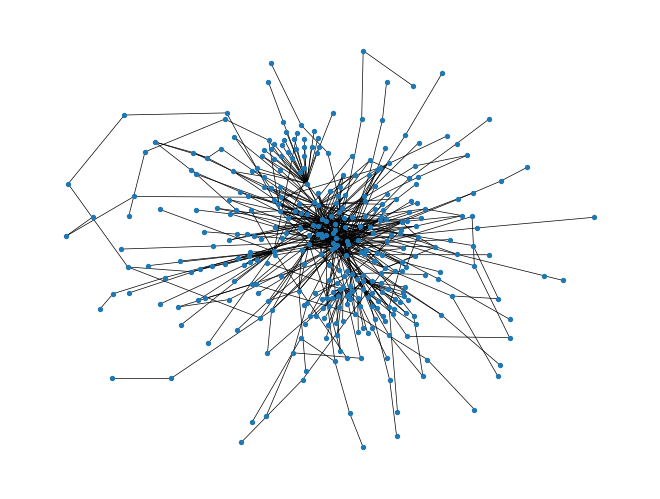

In [7]:
# Draw initial graph
nx.draw(as_graph, width=0.5, node_size=8)

In [6]:
# Implement MoAS detector
def is_moas(adr_dict, pfx, asn):
    # Check if address is truly belong to the asn
    # adr_dict: dictionary of address and the asn they belong too
    # pfx: string of address/mask ('111.111.111.111/22')
    # asn: int (the origin or the last hop in AS path)
    adr,_ = pfx.split('/')
    return adr_dict[adr]['asn'] != asn

In [7]:
# Implement sub-MoAS detector

def is_sub_moas(adr_dict, pfx, asn):
    # MoAS + if mask of prefix is bigger (more specific)
    # adr_dict: dictionary of address and the asn they belong too
    # pfx: string of address/mask ('111.111.111.111/22')
    # asn: int (the origin or the last hop in AS path)
    adr,mask = pfx.split('/')
    if adr_dict[adr]['asn'] != asn:
        if int(mask) > adr_dict[adr]['mask']:
            return True
    return False

In [8]:
# Implement Fake Path detector
def is_fake_path(G, as_path):
    # G: AS graph
    # as path: list of int
    # list of asn nodes that are potentially in graph
    # return true if as_path is in graph, false otherwis
    for i in range(len(as_path)-1):
        if not G.has_edge(as_path[i],as_path[i+1]):
            return True
    return False

In [11]:
# Implement DEFCON #16
def is_defcon(G, adr_dict, pfx, as_path):
    # Check if the as_path is correct but the prefix announced is fake and more specific
    # G: AS graph
    # as path: list of int
    # adr_dict: dictionary of address and the asn they belong too
    # pfx: string of address/mask ('111.111.111.111/22')
    origin = as_path[-1]
    adr,mask = pfx.split('/')
    if (not is_fake_path(G, as_path)) and (origin == adr_dict[adr]['asn']):
        if int(mask) > adr_dict[adr]['mask']:
            return True
    return False

In [10]:
# Detect hijacks for the next stream
import time

# Get data
START_TIME = "2017-07-07 01:00:00"
END_TIME = "2017-07-07 02:00:00 UTC"

stream = pybgpstream.BGPStream(
   from_time=START_TIME, until_time=END_TIME,
   collectors=["route-views.sg", "route-views.eqix"],
   record_type="updates"
)
stream.set_data_interface_option("broker", "cache-dir", "/home/mgumilang/.cache/")

# init dictionary to log time for each hijack (in seconds)
# first-hijack: time to detect the first hijack after running the stream
# log: list of time to take to detect for each element
time_dict = {'moas': {'first-hijack': 0, 'log': []},
             'sub-moas': {'first-hijack': 0, 'log': []},
             'fake-path': {'first-hijack': 0, 'log': []},
             'defcon': {'first-hijack': 0, 'log': []}}

start_stream = time.time()
for rec in stream.records():
   for elem in rec:
      start_elem = time.time()
      # Ignore type 'W' record
      if elem.type == 'W':
         continue
      # Get data from announcement
      peer = str(elem.peer_asn)
      peer_adr = str(elem.peer_address)
      # Get the array of ASns in the AS path and remove repeatedly prepended ASns
      hops = [k for k, g in groupby(elem.fields['as-path'].split(" "))]
      
      # Ignore prefixes that are not in dictionary
      pfx = elem.fields['prefix']
      adr,mask = pfx.split('/')
      if adr not in adr_dict:
         continue

      if hops[0] == peer:
         # Get the origin ASn and its prefix
         origin = hops[-1]

         # Check for MoAS
         if is_moas(adr_dict, pfx, origin):
            time_detect = time.time()
            if time_dict['moas']['first-hijack'] == 0:
               time_dict['moas']['first-hijack'] = time_detect - start_stream
            time_dict['moas']['log'].append(time_detect - start_elem)
            print("Found MoAS ({}): True origin = {}, Hijacker = {}".format(pfx, adr_dict[adr]['asn'], origin))
         
         # Check for Sub-MoAS
         if is_sub_moas(adr_dict, pfx, origin):
            time_detect = time.time()
            if time_dict['sub-moas']['first-hijack'] == 0:
               time_dict['sub-moas']['first-hijack'] = time_detect - start_stream
            time_dict['sub-moas']['log'].append(time_detect - start_elem)
            print("Found Sub-MoAS ({}): True origin = {} with mask = {}, Hijacker = {} with mask = {}".format(
               pfx, adr_dict[adr]['asn'], adr_dict[adr]['mask'], origin, mask))
            
         # Check for Fake AS Path
         if is_fake_path(as_graph, hops):
            time_detect = time.time()
            if time_dict['fake-path']['first-hijack'] == 0:
               time_dict['fake-path']['first-hijack'] = time_detect - start_stream
            time_dict['fake-path']['log'].append(time_detect - start_elem)
            print("Found Fake AS Path: {}, Hijacker = {}".format(hops, origin))

         # Check for DEFCON #16
         if is_defcon(as_graph, adr_dict, pfx, hops):
            time_detect = time.time()
            if time_dict['defcon']['first-hijack'] == 0:
               time_dict['defcon']['first-hijack'] = time_detect - start_stream
            time_dict['defcon']['log'].append(time_detect - start_elem)
            print("Found DEFCON #16({}): True mask = {}, False mask = {}, Hijacker = {}".format(
               pfx, adr_dict[adr]['mask'], mask, origin))

Found DEFCON #16(2804:2cc:8000::/36): True mask = 34, False mask = 36, Hijacker = 262839
Found DEFCON #16(2804:2cc::/34): True mask = 32, False mask = 34, Hijacker = 262839
Found DEFCON #16(2804:2cc::/36): True mask = 32, False mask = 36, Hijacker = 262839
Found DEFCON #16(2804:2414::/48): True mask = 32, False mask = 48, Hijacker = 264200
Found DEFCON #16(2804:2cc:8000::/36): True mask = 34, False mask = 36, Hijacker = 262839
Found DEFCON #16(2804:2cc::/34): True mask = 32, False mask = 34, Hijacker = 262839
Found DEFCON #16(2804:2cc::/36): True mask = 32, False mask = 36, Hijacker = 262839
Found DEFCON #16(157.48.0.0/22): True mask = 14, False mask = 22, Hijacker = 55836
Found DEFCON #16(103.230.50.0/24): True mask = 23, False mask = 24, Hijacker = 133456
Found DEFCON #16(203.23.78.0/24): True mask = 23, False mask = 24, Hijacker = 10223
Found DEFCON #16(220.157.64.0/22): True mask = 19, False mask = 22, Hijacker = 9723
Found MoAS (220.157.68.0/23): True origin = 9268, Hijacker = 972

Found DEFCON #16(173.199.96.0/24): True mask = 21, False mask = 24, Hijacker = 20473
Found DEFCON #16(157.48.0.0/22): True mask = 14, False mask = 22, Hijacker = 55836
Found DEFCON #16(2804:2414::/48): True mask = 32, False mask = 48, Hijacker = 264200
Found DEFCON #16(2804:2cc:8000::/36): True mask = 34, False mask = 36, Hijacker = 262839
Found DEFCON #16(2804:2cc::/34): True mask = 32, False mask = 34, Hijacker = 262839
Found DEFCON #16(2804:2cc::/36): True mask = 32, False mask = 36, Hijacker = 262839
Found Fake AS Path: ['11039', '32787', '22419'], Hijacker = 22419
Found Fake AS Path: ['11039', '32787', '22419'], Hijacker = 22419
Found DEFCON #16(2804:2cc:8000::/36): True mask = 34, False mask = 36, Hijacker = 262839
Found DEFCON #16(2804:2cc::/34): True mask = 32, False mask = 34, Hijacker = 262839
Found DEFCON #16(2804:2cc::/36): True mask = 32, False mask = 36, Hijacker = 262839
Found DEFCON #16(157.48.0.0/22): True mask = 14, False mask = 22, Hijacker = 55836
Found DEFCON #16(1

Found Fake AS Path: ['11039', '4826', '45437', '38829'], Hijacker = 38829
Found Fake AS Path: ['11039', '4826', '45437', '38829'], Hijacker = 38829
Found Fake AS Path: ['11039', '4826', '45437', '38829'], Hijacker = 38829
Found Fake AS Path: ['11039', '4826', '38716'], Hijacker = 38716
Found Fake AS Path: ['11039', '4826', '38716'], Hijacker = 38716
Found Fake AS Path: ['11039', '4826', '17819', '24570'], Hijacker = 24570
Found Fake AS Path: ['11039', '4826', '9268'], Hijacker = 9268
Found Fake AS Path: ['11039', '4826', '9268'], Hijacker = 9268
Found Fake AS Path: ['11039', '4826', '9268'], Hijacker = 9268
Found Fake AS Path: ['11039', '4826', '9268'], Hijacker = 9268
Found Fake AS Path: ['11039', '4826', '9268'], Hijacker = 9268
Found Fake AS Path: ['11039', '4826', '9268'], Hijacker = 9268
Found Fake AS Path: ['11039', '4826', '9268'], Hijacker = 9268
Found Fake AS Path: ['11039', '4826', '9268'], Hijacker = 9268
Found Fake AS Path: ['11039', '4826', '9268'], Hijacker = 9268
Found F

Found Fake AS Path: ['11039', '4826', '24479'], Hijacker = 24479
Found Fake AS Path: ['11039', '4826', '24479'], Hijacker = 24479
Found Fake AS Path: ['11039', '4826', '24479'], Hijacker = 24479
Found Fake AS Path: ['11039', '4826', '24479'], Hijacker = 24479
Found Fake AS Path: ['11039', '4826', '9443'], Hijacker = 9443
Found Fake AS Path: ['11039', '4826', '9443'], Hijacker = 9443
Found Fake AS Path: ['11039', '4826', '9443'], Hijacker = 9443
Found Fake AS Path: ['11039', '4826', '9443'], Hijacker = 9443
Found Fake AS Path: ['11039', '4826', '9443'], Hijacker = 9443
Found Fake AS Path: ['11039', '4826', '9443'], Hijacker = 9443
Found Fake AS Path: ['11039', '4826', '9443'], Hijacker = 9443
Found Fake AS Path: ['11039', '4826', '9443'], Hijacker = 9443
Found Fake AS Path: ['11039', '4826', '9443'], Hijacker = 9443
Found Fake AS Path: ['11039', '4826', '9443'], Hijacker = 9443
Found Fake AS Path: ['11039', '4826', '9443'], Hijacker = 9443
Found Fake AS Path: ['11039', '4826', '9443'], 

Found Fake AS Path: ['11039', '4826', '7594'], Hijacker = 7594
Found Fake AS Path: ['11039', '4826', '9443'], Hijacker = 9443
Found Fake AS Path: ['11039', '4826', '9443'], Hijacker = 9443
Found Fake AS Path: ['11039', '4826', '9443'], Hijacker = 9443
Found Fake AS Path: ['11039', '4826', '9443'], Hijacker = 9443
Found Fake AS Path: ['11039', '4826', '9443'], Hijacker = 9443
Found Fake AS Path: ['11039', '4826', '9443'], Hijacker = 9443
Found Fake AS Path: ['11039', '4826', '9443'], Hijacker = 9443
Found Fake AS Path: ['11039', '4826', '9443'], Hijacker = 9443
Found Fake AS Path: ['11039', '4826', '9443'], Hijacker = 9443
Found Fake AS Path: ['11039', '4826', '9443'], Hijacker = 9443
Found Fake AS Path: ['11039', '4826', '9443'], Hijacker = 9443
Found Fake AS Path: ['11039', '4826', '9443'], Hijacker = 9443
Found Fake AS Path: ['11039', '4826', '9443'], Hijacker = 9443
Found Fake AS Path: ['11039', '4826', '9443'], Hijacker = 9443
Found Fake AS Path: ['11039', '4826', '9443'], Hijacker

Found Fake AS Path: ['11039', '4826', '9443'], Hijacker = 9443
Found Fake AS Path: ['11039', '4826', '9443'], Hijacker = 9443
Found Fake AS Path: ['11039', '4826', '9443'], Hijacker = 9443
Found Fake AS Path: ['11039', '4826', '9443'], Hijacker = 9443
Found Fake AS Path: ['11039', '4826', '9443'], Hijacker = 9443
Found Fake AS Path: ['11039', '4826', '9443'], Hijacker = 9443
Found Fake AS Path: ['11039', '4826', '9443'], Hijacker = 9443
Found Fake AS Path: ['11039', '4826', '9443'], Hijacker = 9443
Found Fake AS Path: ['11039', '4826', '9443'], Hijacker = 9443
Found Fake AS Path: ['11039', '4826', '9443'], Hijacker = 9443
Found Fake AS Path: ['11039', '4826', '9443'], Hijacker = 9443
Found Fake AS Path: ['11039', '4826', '9443'], Hijacker = 9443
Found Fake AS Path: ['11039', '4826', '9503'], Hijacker = 9503
Found Fake AS Path: ['11039', '4826'], Hijacker = 4826
Found Fake AS Path: ['11039', '4826'], Hijacker = 4826
Found Fake AS Path: ['11039', '4826', '9443'], Hijacker = 9443
Found Fa

Found DEFCON #16(203.20.160.0/20): True mask = 19, False mask = 20, Hijacker = 37998
Found DEFCON #16(210.79.16.0/24): True mask = 23, False mask = 24, Hijacker = 45411
Found DEFCON #16(118.107.60.0/24): True mask = 23, False mask = 24, Hijacker = 45411
Found DEFCON #16(210.79.26.0/24): True mask = 23, False mask = 24, Hijacker = 45411
Found DEFCON #16(210.79.18.0/24): True mask = 23, False mask = 24, Hijacker = 45411
Found DEFCON #16(199.65.208.0/24): True mask = 21, False mask = 24, Hijacker = 13778
Found DEFCON #16(222.255.144.0/24): True mask = 21, False mask = 24, Hijacker = 45899
Found DEFCON #16(203.30.100.0/23): True mask = 22, False mask = 23, Hijacker = 24316
Found DEFCON #16(140.149.0.0/17): True mask = 16, False mask = 17, Hijacker = 7693
Found MoAS (222.255.248.0/21): True origin = 7643, Hijacker = {7643}
Found DEFCON #16(222.255.8.0/23): True mask = 21, False mask = 23, Hijacker = 7643
Found MoAS (222.255.192.0/19): True origin = 45899, Hijacker = 7643
Found MoAS (222.255

Found DEFCON #16(103.26.16.0/24): True mask = 22, False mask = 24, Hijacker = 132857
Found DEFCON #16(43.243.56.0/24): True mask = 22, False mask = 24, Hijacker = 132857
Found DEFCON #16(2a05:b0c6::/32): True mask = 31, False mask = 32, Hijacker = 203661
Found DEFCON #16(2a07:1c44::/32): True mask = 30, False mask = 32, Hijacker = 203661
Found DEFCON #16(157.48.0.0/22): True mask = 14, False mask = 22, Hijacker = 55836
Found Fake AS Path: ['6079', '7738', '8167', '262675', '262865', '262354', '262286'], Hijacker = 262286
Found Fake AS Path: ['6079', '32787', '22419'], Hijacker = 22419
Found Fake AS Path: ['6079', '32787', '22419'], Hijacker = 22419
Found DEFCON #16(43.243.56.0/24): True mask = 22, False mask = 24, Hijacker = 132857
Found DEFCON #16(103.26.16.0/24): True mask = 22, False mask = 24, Hijacker = 132857
Found DEFCON #16(103.26.16.0/24): True mask = 22, False mask = 24, Hijacker = 132857
Found DEFCON #16(103.26.16.0/24): True mask = 22, False mask = 24, Hijacker = 132857
Fou

Found DEFCON #16(43.243.56.0/24): True mask = 22, False mask = 24, Hijacker = 132857
Found DEFCON #16(103.26.16.0/24): True mask = 22, False mask = 24, Hijacker = 132857
Found DEFCON #16(190.115.128.0/22): True mask = 18, False mask = 22, Hijacker = 52260
Found Fake AS Path: ['3257', '286', '7738', '8167', '262675', '262865', '262354', '52561'], Hijacker = 52561
Found Fake AS Path: ['3257', '1239', '7738', '8167', '262675', '262865', '262354', '262286'], Hijacker = 262286
Found DEFCON #16(2804:2cc:8000::/36): True mask = 34, False mask = 36, Hijacker = 262839
Found DEFCON #16(2804:2cc::/34): True mask = 32, False mask = 34, Hijacker = 262839
Found DEFCON #16(2804:2cc::/36): True mask = 32, False mask = 36, Hijacker = 262839
Found Fake AS Path: ['18106', '32787', '22419'], Hijacker = 22419
Found Fake AS Path: ['18106', '32787', '22419'], Hijacker = 22419
Found Fake AS Path: ['24482', '32787', '22419'], Hijacker = 22419
Found Fake AS Path: ['24482', '32787', '22419'], Hijacker = 22419
Fo

Found DEFCON #16(93.181.208.0/21): True mask = 20, False mask = 21, Hijacker = 13118
Found DEFCON #16(24.123.152.0/22): True mask = 21, False mask = 22, Hijacker = 10796
Found DEFCON #16(24.145.128.0/21): True mask = 17, False mask = 21, Hijacker = 10796
Found MoAS (24.172.240.0/24): True origin = 10796, Hijacker = 36495
Found Sub-MoAS (24.172.240.0/24): True origin = 10796 with mask = 21, Hijacker = 36495 with mask = 24
Found DEFCON #16(24.123.128.0/20): True mask = 19, False mask = 20, Hijacker = 10796
Found DEFCON #16(24.123.64.0/20): True mask = 19, False mask = 20, Hijacker = 10796
Found DEFCON #16(24.145.128.0/19): True mask = 17, False mask = 19, Hijacker = 10796
Found MoAS (70.61.32.0/24): True origin = 10796, Hijacker = 23435
Found Sub-MoAS (70.61.32.0/24): True origin = 10796 with mask = 19, Hijacker = 23435 with mask = 24
Found DEFCON #16(5.143.160.0/21): True mask = 20, False mask = 21, Hijacker = 21378
Found DEFCON #16(5.143.160.0/21): True mask = 20, False mask = 21, Hija

Found Fake AS Path: ['133165', '3491', '12389', '21378', '203290'], Hijacker = 203290
Found Fake AS Path: ['133165', '3491', '12389', '21378', '203290'], Hijacker = 203290
Found Fake AS Path: ['133165', '3491', '12389', '21378', '203290'], Hijacker = 203290
Found Fake AS Path: ['133165', '3491', '12389', '21378', '203290'], Hijacker = 203290
Found Fake AS Path: ['133165', '3491', '12389', '21378', '203290'], Hijacker = 203290
Found Fake AS Path: ['133165', '3491', '12389', '21378', '203290'], Hijacker = 203290
Found DEFCON #16(186.195.170.0/24): True mask = 23, False mask = 24, Hijacker = 262738
Found DEFCON #16(87.253.24.0/22): True mask = 21, False mask = 22, Hijacker = 13118
Found DEFCON #16(109.161.64.0/21): True mask = 19, False mask = 21, Hijacker = 13118
Found DEFCON #16(87.253.16.0/22): True mask = 21, False mask = 22, Hijacker = 13118
Found DEFCON #16(95.86.192.0/21): True mask = 19, False mask = 21, Hijacker = 13118
Found DEFCON #16(186.195.170.0/24): True mask = 23, False ma

Found DEFCON #16(109.62.128.0/21): True mask = 17, False mask = 21, Hijacker = 29456
Found DEFCON #16(95.71.0.0/22): True mask = 17, False mask = 22, Hijacker = 29456
Found DEFCON #16(5.143.128.0/21): True mask = 19, False mask = 21, Hijacker = 29456
Found DEFCON #16(93.181.208.0/21): True mask = 20, False mask = 21, Hijacker = 13118
Found DEFCON #16(109.161.64.0/20): True mask = 19, False mask = 20, Hijacker = 13118
Found DEFCON #16(87.253.0.0/20): True mask = 19, False mask = 20, Hijacker = 13118
Found DEFCON #16(95.86.224.0/21): True mask = 19, False mask = 21, Hijacker = 13118
Found DEFCON #16(109.161.32.0/21): True mask = 19, False mask = 21, Hijacker = 13118
Found DEFCON #16(87.253.0.0/21): True mask = 19, False mask = 21, Hijacker = 13118
Found DEFCON #16(95.106.160.0/21): True mask = 19, False mask = 21, Hijacker = 13118
Found DEFCON #16(2804:2cc::/36): True mask = 32, False mask = 36, Hijacker = 262839
Found DEFCON #16(2804:2cc::/34): True mask = 32, False mask = 34, Hijacker 

Found DEFCON #16(138.0.164.0/24): True mask = 22, False mask = 24, Hijacker = 264557
Found DEFCON #16(95.71.0.0/22): True mask = 17, False mask = 22, Hijacker = 29456
Found DEFCON #16(109.62.128.0/21): True mask = 17, False mask = 21, Hijacker = 29456
Found DEFCON #16(5.143.128.0/21): True mask = 19, False mask = 21, Hijacker = 29456
Found DEFCON #16(138.0.164.0/24): True mask = 22, False mask = 24, Hijacker = 264557
Found DEFCON #16(5.143.128.0/21): True mask = 19, False mask = 21, Hijacker = 29456
Found DEFCON #16(95.71.0.0/22): True mask = 17, False mask = 22, Hijacker = 29456
Found DEFCON #16(109.62.128.0/21): True mask = 17, False mask = 21, Hijacker = 29456
Found DEFCON #16(94.241.0.0/21): True mask = 18, False mask = 21, Hijacker = 21378
Found DEFCON #16(95.106.128.0/21): True mask = 19, False mask = 21, Hijacker = 21378
Found DEFCON #16(84.42.0.0/21): True mask = 19, False mask = 21, Hijacker = 21378
Found DEFCON #16(84.42.0.0/21): True mask = 19, False mask = 21, Hijacker = 21

Found DEFCON #16(124.171.0.0/20): True mask = 18, False mask = 20, Hijacker = 4739
Found DEFCON #16(203.173.0.0/21): True mask = 20, False mask = 21, Hijacker = 4739
Found DEFCON #16(203.217.58.0/24): True mask = 23, False mask = 24, Hijacker = 4739
Found DEFCON #16(203.217.58.0/24): True mask = 23, False mask = 24, Hijacker = 4739
Found DEFCON #16(203.173.0.0/21): True mask = 20, False mask = 21, Hijacker = 4739
Found DEFCON #16(203.214.64.0/24): True mask = 21, False mask = 24, Hijacker = 4739
Found DEFCON #16(203.217.58.0/24): True mask = 23, False mask = 24, Hijacker = 4739
Found DEFCON #16(203.173.0.0/21): True mask = 20, False mask = 21, Hijacker = 4739
Found DEFCON #16(203.214.64.0/24): True mask = 21, False mask = 24, Hijacker = 4739
Found DEFCON #16(203.217.58.0/24): True mask = 23, False mask = 24, Hijacker = 4739
Found DEFCON #16(203.173.0.0/21): True mask = 20, False mask = 21, Hijacker = 4739
Found DEFCON #16(93.170.178.0/24): True mask = 23, False mask = 24, Hijacker = 41

Found DEFCON #16(170.83.124.0/24): True mask = 22, False mask = 24, Hijacker = 263774
Found DEFCON #16(201.216.252.0/24): True mask = 22, False mask = 24, Hijacker = 16814
Found MoAS (190.0.160.0/24): True origin = 3356, Hijacker = 28111
Found Sub-MoAS (190.0.160.0/24): True origin = 3356 with mask = 19, Hijacker = 28111 with mask = 24
Found MoAS (190.106.132.0/22): True origin = 52236, Hijacker = 7303
Found DEFCON #16(190.185.194.0/24): True mask = 23, False mask = 24, Hijacker = 27983
Found MoAS (200.81.192.0/24): True origin = 19037, Hijacker = 17401
Found Sub-MoAS (200.81.192.0/24): True origin = 19037 with mask = 20, Hijacker = 17401 with mask = 24
Found DEFCON #16(190.106.132.0/23): True mask = 22, False mask = 23, Hijacker = 52236
Found DEFCON #16(190.185.216.0/24): True mask = 22, False mask = 24, Hijacker = 27983
Found DEFCON #16(190.182.130.0/24): True mask = 23, False mask = 24, Hijacker = 27983
Found DEFCON #16(190.182.146.0/24): True mask = 23, False mask = 24, Hijacker = 

Found DEFCON #16(170.83.124.0/24): True mask = 22, False mask = 24, Hijacker = 263774
Found MoAS (190.106.128.0/22): True origin = 52236, Hijacker = 7303
Found DEFCON #16(186.190.180.0/24): True mask = 23, False mask = 24, Hijacker = 27987
Found DEFCON #16(190.182.130.0/24): True mask = 23, False mask = 24, Hijacker = 27983
Found DEFCON #16(190.106.128.0/23): True mask = 22, False mask = 23, Hijacker = 52236
Found DEFCON #16(190.106.144.0/23): True mask = 22, False mask = 23, Hijacker = 52236
Found DEFCON #16(168.227.204.0/24): True mask = 23, False mask = 24, Hijacker = 27987
Found DEFCON #16(190.31.0.0/21): True mask = 16, False mask = 21, Hijacker = 7303
Found DEFCON #16(181.189.172.0/24): True mask = 23, False mask = 24, Hijacker = 27987
Found DEFCON #16(190.182.146.0/24): True mask = 23, False mask = 24, Hijacker = 27983
Found DEFCON #16(190.182.210.0/24): True mask = 23, False mask = 24, Hijacker = 27983
Found DEFCON #16(201.216.252.0/24): True mask = 22, False mask = 24, Hijacke

Found DEFCON #16(190.2.0.0/24): True mask = 22, False mask = 24, Hijacker = 16814
Found DEFCON #16(190.2.32.0/22): True mask = 19, False mask = 22, Hijacker = 16814
Found DEFCON #16(186.64.96.0/24): True mask = 21, False mask = 24, Hijacker = 52430
Found DEFCON #16(186.64.98.0/24): True mask = 23, False mask = 24, Hijacker = 52430
Found DEFCON #16(186.64.100.0/24): True mask = 22, False mask = 24, Hijacker = 52430
Found DEFCON #16(190.106.144.0/24): True mask = 22, False mask = 24, Hijacker = 52236
Found DEFCON #16(200.115.72.0/24): True mask = 21, False mask = 24, Hijacker = 18667
Found DEFCON #16(186.190.180.0/24): True mask = 23, False mask = 24, Hijacker = 27987
Found DEFCON #16(170.83.124.0/24): True mask = 22, False mask = 24, Hijacker = 263774
Found DEFCON #16(189.113.8.0/24): True mask = 22, False mask = 24, Hijacker = 28209
Found DEFCON #16(168.227.204.0/24): True mask = 23, False mask = 24, Hijacker = 27987
Found DEFCON #16(181.189.172.0/24): True mask = 23, False mask = 24, 

Found DEFCON #16(116.84.0.0/19): True mask = 16, False mask = 19, Hijacker = 23908
Found DEFCON #16(87.253.16.0/22): True mask = 21, False mask = 22, Hijacker = 13118
Found DEFCON #16(109.161.64.0/21): True mask = 19, False mask = 21, Hijacker = 13118
Found DEFCON #16(97.67.240.0/22): True mask = 21, False mask = 22, Hijacker = 27338
Found DEFCON #16(97.67.240.0/22): True mask = 21, False mask = 22, Hijacker = 27338
Found DEFCON #16(97.67.240.0/22): True mask = 21, False mask = 22, Hijacker = 27338
Found DEFCON #16(97.67.240.0/22): True mask = 21, False mask = 22, Hijacker = 27338
Found DEFCON #16(210.121.0.0/21): True mask = 17, False mask = 21, Hijacker = 45374
Found DEFCON #16(97.67.240.0/22): True mask = 21, False mask = 22, Hijacker = 27338
Found DEFCON #16(97.67.240.0/22): True mask = 21, False mask = 22, Hijacker = 27338
Found DEFCON #16(97.67.240.0/22): True mask = 21, False mask = 22, Hijacker = 27338
Found DEFCON #16(162.212.84.0/23): True mask = 22, False mask = 23, Hijacker

Found DEFCON #16(220.66.116.0/24): True mask = 22, False mask = 24, Hijacker = 3786
Found DEFCON #16(210.180.32.0/20): True mask = 19, False mask = 20, Hijacker = 4663
Found DEFCON #16(210.126.128.0/24): True mask = 17, False mask = 24, Hijacker = 9632
Found DEFCON #16(210.122.16.0/22): True mask = 20, False mask = 22, Hijacker = 3786
Found MoAS (203.237.172.0/23): True origin = 18031, Hijacker = 3786
Found DEFCON #16(203.237.128.0/19): True mask = 17, False mask = 19, Hijacker = 3786
Found DEFCON #16(210.107.240.0/23): True mask = 22, False mask = 23, Hijacker = 9870
Found DEFCON #16(211.44.0.0/23): True mask = 16, False mask = 23, Hijacker = 55592
Found DEFCON #16(210.180.32.0/20): True mask = 19, False mask = 20, Hijacker = 4663
Found DEFCON #16(203.255.212.0/23): True mask = 22, False mask = 23, Hijacker = 18023
Found MoAS (170.51.243.0/24): True origin = 11664, Hijacker = 19037
Found MoAS (210.97.148.0/24): True origin = 3786, Hijacker = 38111
Found Sub-MoAS (210.97.148.0/24): Tru

Found DEFCON #16(2a00:1b50::/48): True mask = 32, False mask = 48, Hijacker = 8343
Found DEFCON #16(157.48.0.0/22): True mask = 14, False mask = 22, Hijacker = 55836
Found DEFCON #16(157.48.0.0/22): True mask = 14, False mask = 22, Hijacker = 55836
Found DEFCON #16(157.48.0.0/22): True mask = 14, False mask = 22, Hijacker = 55836
Found DEFCON #16(157.48.0.0/22): True mask = 14, False mask = 22, Hijacker = 55836
Found DEFCON #16(157.48.0.0/22): True mask = 14, False mask = 22, Hijacker = 55836
Found DEFCON #16(157.48.0.0/22): True mask = 14, False mask = 22, Hijacker = 55836
Found DEFCON #16(2a05:b0c6::/32): True mask = 31, False mask = 32, Hijacker = 203661
Found DEFCON #16(2a07:1c44::/32): True mask = 30, False mask = 32, Hijacker = 203661
Found MoAS (165.98.112.0/24): True origin = 27742, Hijacker = 2638
Found Sub-MoAS (165.98.112.0/24): True origin = 27742 with mask = 20, Hijacker = 2638 with mask = 24
Found Fake AS Path: ['2914', '701', '262206', '27742', '2638'], Hijacker = 2638
F

Found MoAS (202.160.224.0/21): True origin = 7473, Hijacker = 3758
Found Sub-MoAS (202.160.224.0/21): True origin = 7473 with mask = 19, Hijacker = 3758 with mask = 21
Found DEFCON #16(42.61.0.0/17): True mask = 16, False mask = 17, Hijacker = 3758
Found DEFCON #16(118.201.0.0/24): True mask = 17, False mask = 24, Hijacker = 3758
Found DEFCON #16(157.48.0.0/22): True mask = 14, False mask = 22, Hijacker = 55836
Found Fake AS Path: ['11039', '174', '59560'], Hijacker = 59560
Found DEFCON #16(177.129.252.0/24): True mask = 22, False mask = 24, Hijacker = 28335
Found MoAS (130.36.148.0/22): True origin = 9255, Hijacker = 32528
Found DEFCON #16(103.84.174.0/24): True mask = 23, False mask = 24, Hijacker = 136246
Found DEFCON #16(103.84.172.0/23): True mask = 22, False mask = 23, Hijacker = 136246
Found DEFCON #16(103.84.172.0/24): True mask = 22, False mask = 24, Hijacker = 136246
Found DEFCON #16(190.115.178.0/24): True mask = 23, False mask = 24, Hijacker = 52260
Found DEFCON #16(190.102

Found Fake AS Path: ['24482', '3255', '30886'], Hijacker = 30886
Found Fake AS Path: ['24482', '3255', '30886'], Hijacker = 30886
Found Fake AS Path: ['24482', '3255', '30886'], Hijacker = 30886
Found Fake AS Path: ['24482', '3255', '30886'], Hijacker = 30886
Found Fake AS Path: ['24482', '3255', '30886'], Hijacker = 30886
Found Fake AS Path: ['24482', '3255', '30886'], Hijacker = 30886
Found Fake AS Path: ['24482', '3255', '30886'], Hijacker = 30886
Found Fake AS Path: ['24482', '3255', '30886'], Hijacker = 30886
Found Fake AS Path: ['24482', '3255', '30886'], Hijacker = 30886
Found Fake AS Path: ['24482', '3255', '30886'], Hijacker = 30886
Found Fake AS Path: ['24482', '3255', '30886'], Hijacker = 30886
Found Fake AS Path: ['24482', '3255', '196808'], Hijacker = 196808
Found Fake AS Path: ['24482', '3255', '34661'], Hijacker = 34661
Found Fake AS Path: ['24482', '3255', '35362'], Hijacker = 35362
Found Fake AS Path: ['24482', '3255', '35362'], Hijacker = 35362
Found Fake AS Path: ['2

Found Fake AS Path: ['133165', '3491', '3257', '21488', '13121', '42512'], Hijacker = 42512
Found Fake AS Path: ['133165', '3491', '3257', '21488', '13121', '42512'], Hijacker = 42512
Found Fake AS Path: ['133165', '3491', '3257', '21488', '56527'], Hijacker = 56527
Found Fake AS Path: ['133165', '3491', '3257', '21488', '56527'], Hijacker = 56527
Found Fake AS Path: ['133165', '3491', '3257', '21488', '56527'], Hijacker = 56527
Found Fake AS Path: ['133165', '3491', '3257', '21488', '48230'], Hijacker = 48230
Found Fake AS Path: ['133165', '3491', '3257', '21488', '48230'], Hijacker = 48230
Found Fake AS Path: ['133165', '3491', '3257', '21488', '48230'], Hijacker = 48230
Found Fake AS Path: ['133165', '3491', '3257', '21488', '29637'], Hijacker = 29637
Found Fake AS Path: ['133165', '3491', '3257', '21488', '29637'], Hijacker = 29637
Found Fake AS Path: ['133165', '3491', '3257', '21488', '48106'], Hijacker = 48106
Found Fake AS Path: ['133165', '3491', '3257', '21488', '13121'], Hij

Found Sub-MoAS (165.98.112.0/24): True origin = 27742 with mask = 20, Hijacker = 2638 with mask = 24
Found Fake AS Path: ['5769', '1299', '3356', '262206', '27742', '2638'], Hijacker = 2638
Found DEFCON #16(177.72.44.0/24): True mask = 22, False mask = 24, Hijacker = 52813
Found Fake AS Path: ['5769', '6453', '3257', '21488', '48239', '41588'], Hijacker = 41588
Found Fake AS Path: ['5769', '6453', '3257', '21488', '48239', '41588'], Hijacker = 41588
Found Fake AS Path: ['24482', '3255'], Hijacker = 3255
Found Fake AS Path: ['24482', '3255'], Hijacker = 3255
Found Fake AS Path: ['24482', '3255', '6702', '47590'], Hijacker = 47590
Found Fake AS Path: ['24482', '3255', '34251', '31158'], Hijacker = 31158
Found Fake AS Path: ['24482', '3255', '34251', '31158'], Hijacker = 31158
Found DEFCON #16(177.72.44.0/24): True mask = 22, False mask = 24, Hijacker = 52813
Found Fake AS Path: ['24482', '3255', '50392'], Hijacker = 50392
Found Fake AS Path: ['24482', '3255', '50392'], Hijacker = 50392
F

Found DEFCON #16(170.83.186.0/24): True mask = 23, False mask = 24, Hijacker = 266487
Found DEFCON #16(170.83.184.0/24): True mask = 22, False mask = 24, Hijacker = 266487
Found DEFCON #16(170.83.186.0/24): True mask = 23, False mask = 24, Hijacker = 266487
Found DEFCON #16(170.83.184.0/24): True mask = 22, False mask = 24, Hijacker = 266487
Found DEFCON #16(170.83.186.0/24): True mask = 23, False mask = 24, Hijacker = 266487
Found DEFCON #16(170.83.184.0/24): True mask = 22, False mask = 24, Hijacker = 266487
Found MoAS (170.239.254.0/24): True origin = 266360, Hijacker = 262314
Found DEFCON #16(170.83.186.0/24): True mask = 23, False mask = 24, Hijacker = 266487
Found DEFCON #16(170.83.184.0/24): True mask = 22, False mask = 24, Hijacker = 266487
Found DEFCON #16(172.96.144.0/23): True mask = 21, False mask = 23, Hijacker = 7828
Found DEFCON #16(216.171.176.0/21): True mask = 20, False mask = 21, Hijacker = 7828
Found MoAS (41.243.3.0/24): True origin = 37020, Hijacker = 327707
Found

Found DEFCON #16(61.246.56.0/23): True mask = 22, False mask = 23, Hijacker = 9498
Found DEFCON #16(2804:2414::/48): True mask = 32, False mask = 48, Hijacker = 264200
Found DEFCON #16(117.227.0.0/20): True mask = 18, False mask = 20, Hijacker = 9829
Found DEFCON #16(117.243.192.0/20): True mask = 18, False mask = 20, Hijacker = 9829
Found DEFCON #16(117.237.192.0/20): True mask = 18, False mask = 20, Hijacker = 9829
Found DEFCON #16(2804:2cc:8000::/36): True mask = 34, False mask = 36, Hijacker = 262839
Found DEFCON #16(2804:2cc::/34): True mask = 32, False mask = 34, Hijacker = 262839
Found DEFCON #16(2804:2cc::/36): True mask = 32, False mask = 36, Hijacker = 262839
Found MoAS (170.239.254.0/24): True origin = 266360, Hijacker = 262314
Found MoAS (170.51.243.0/24): True origin = 11664, Hijacker = 19037
Found MoAS (170.239.254.0/24): True origin = 266360, Hijacker = 262314
Found Fake AS Path: ['24482', '45204'], Hijacker = 45204
Found DEFCON #16(2804:2414::/48): True mask = 32, False

Found Fake AS Path: ['24482', '3255', '50579'], Hijacker = 50579
Found Fake AS Path: ['24482', '3255', '50579'], Hijacker = 50579
Found Fake AS Path: ['24482', '3255', '25282'], Hijacker = 25282
Found Fake AS Path: ['24482', '3255', '6723', '43967'], Hijacker = 43967
Found Fake AS Path: ['24482', '3255', '15595', '51367'], Hijacker = 51367
Found Fake AS Path: ['24482', '3255', '39422'], Hijacker = 39422
Found Fake AS Path: ['24482', '3255', '31234'], Hijacker = 31234
Found Fake AS Path: ['24482', '3255', '6723', '13307'], Hijacker = 13307
Found Fake AS Path: ['24482', '3255', '41649'], Hijacker = 41649
Found Fake AS Path: ['24482', '3255', '34251', '31158'], Hijacker = 31158
Found Fake AS Path: ['24482', '3255', '6702'], Hijacker = 6702
Found DEFCON #16(2a00:1b50::/48): True mask = 32, False mask = 48, Hijacker = 8343
Found DEFCON #16(2804:2cc:8000::/36): True mask = 34, False mask = 36, Hijacker = 262839
Found Fake AS Path: ['24482', '3255', '6702', '5530'], Hijacker = 5530
Found Fake

Found DEFCON #16(186.1.200.0/24): True mask = 22, False mask = 24, Hijacker = 52260
Found DEFCON #16(186.1.192.0/22): True mask = 20, False mask = 22, Hijacker = 52260
Found DEFCON #16(77.220.192.0/24): True mask = 21, False mask = 24, Hijacker = 42654
Found DEFCON #16(77.220.200.0/24): True mask = 22, False mask = 24, Hijacker = 42654
Found DEFCON #16(185.149.8.0/24): True mask = 22, False mask = 24, Hijacker = 42654
Found MoAS (170.239.254.0/24): True origin = 266360, Hijacker = 262314
Found MoAS (217.65.248.0/24): True origin = 59671, Hijacker = 3255
Found Sub-MoAS (217.65.248.0/24): True origin = 59671 with mask = 21, Hijacker = 3255 with mask = 24
Found Fake AS Path: ['19151', '6327', '12075'], Hijacker = 12075
Found DEFCON #16(67.216.0.0/21): True mask = 20, False mask = 21, Hijacker = 7828
Found DEFCON #16(172.97.96.0/24): True mask = 22, False mask = 24, Hijacker = 7828
Found DEFCON #16(190.115.128.0/22): True mask = 18, False mask = 22, Hijacker = 52260
Found DEFCON #16(186.1.

Found DEFCON #16(213.55.112.0/24): True mask = 21, False mask = 24, Hijacker = 24757
Found DEFCON #16(197.156.112.0/24): True mask = 22, False mask = 24, Hijacker = 24757
Found MoAS (168.88.72.0/24): True origin = 12075, Hijacker = 65150
Found Fake AS Path: ['24482', '174', '6327', '12075', '65150'], Hijacker = 65150
Found DEFCON #16(197.156.110.0/24): True mask = 23, False mask = 24, Hijacker = 24757
Found Fake AS Path: ['6939', '6762', '17494', '17806', '45532'], Hijacker = 45532
Found DEFCON #16(197.156.110.0/24): True mask = 23, False mask = 24, Hijacker = 24757
Found DEFCON #16(197.156.110.0/24): True mask = 23, False mask = 24, Hijacker = 24757
Found Fake AS Path: ['2914', '6453', '17494', '17806', '45532'], Hijacker = 45532
Found Fake AS Path: ['4589', '3257', '7473', '17494', '17806', '45532'], Hijacker = 45532
Found Fake AS Path: ['4589', '7473', '17494', '17806', '45532'], Hijacker = 45532
Found DEFCON #16(197.156.112.0/24): True mask = 22, False mask = 24, Hijacker = 24757
F

Found DEFCON #16(2804:2cc:8000::/36): True mask = 34, False mask = 36, Hijacker = 262839
Found DEFCON #16(2804:2cc::/34): True mask = 32, False mask = 34, Hijacker = 262839
Found DEFCON #16(2804:2cc::/36): True mask = 32, False mask = 36, Hijacker = 262839
Found Fake AS Path: ['38880', '58601', '174', '9498', '58715', '136514', '63844'], Hijacker = 63844
Found DEFCON #16(197.156.112.0/24): True mask = 22, False mask = 24, Hijacker = 24757
Found DEFCON #16(213.55.112.0/24): True mask = 21, False mask = 24, Hijacker = 24757
Found Fake AS Path: ['11039', '11557', '4436', '4837', '197407'], Hijacker = 197407
Found DEFCON #16(2804:2cc:8000::/36): True mask = 34, False mask = 36, Hijacker = 262839
Found DEFCON #16(2804:2cc::/34): True mask = 32, False mask = 34, Hijacker = 262839
Found DEFCON #16(2804:2cc::/36): True mask = 32, False mask = 36, Hijacker = 262839
Found DEFCON #16(2804:2414::/48): True mask = 32, False mask = 48, Hijacker = 264200
Found DEFCON #16(2804:2414::/48): True mask = 

Found DEFCON #16(2804:2414::/48): True mask = 32, False mask = 48, Hijacker = 264200
Found DEFCON #16(2804:2cc:8000::/36): True mask = 34, False mask = 36, Hijacker = 262839
Found MoAS (170.51.243.0/24): True origin = 11664, Hijacker = 19037
Found Fake AS Path: ['5769', '6453', '7018', '19542'], Hijacker = 19542
Found DEFCON #16(116.206.252.0/24): True mask = 22, False mask = 24, Hijacker = 63844
Found DEFCON #16(41.77.192.0/22): True mask = 21, False mask = 22, Hijacker = 37213
Found MoAS (186.182.234.0/24): True origin = 11664, Hijacker = 19037
Found DEFCON #16(183.182.92.0/24): True mask = 22, False mask = 24, Hijacker = 46016
Found DEFCON #16(2804:2cc:8000::/36): True mask = 34, False mask = 36, Hijacker = 262839
Found DEFCON #16(2804:2414::/48): True mask = 32, False mask = 48, Hijacker = 264200
Found DEFCON #16(2804:2cc::/34): True mask = 32, False mask = 34, Hijacker = 262839
Found DEFCON #16(2804:2cc::/36): True mask = 32, False mask = 36, Hijacker = 262839
Found DEFCON #16(2a0

Found MoAS (170.239.254.0/24): True origin = 266360, Hijacker = 262314
Found MoAS (205.57.80.0/24): True origin = 5976, Hijacker = 647
Found MoAS (170.239.254.0/24): True origin = 266360, Hijacker = 262314
Found DEFCON #16(116.206.252.0/24): True mask = 22, False mask = 24, Hijacker = 63844
Found DEFCON #16(116.206.252.0/24): True mask = 22, False mask = 24, Hijacker = 63844
Found DEFCON #16(116.206.252.0/24): True mask = 22, False mask = 24, Hijacker = 63844
Found DEFCON #16(170.83.184.0/24): True mask = 22, False mask = 24, Hijacker = 266487
Found DEFCON #16(170.83.186.0/24): True mask = 23, False mask = 24, Hijacker = 266487
Found DEFCON #16(116.206.252.0/24): True mask = 22, False mask = 24, Hijacker = 63844
Found DEFCON #16(13.15.32.0/20): True mask = 19, False mask = 20, Hijacker = 22390
Found Fake AS Path: ['6079', '3356', '7018', '19542'], Hijacker = 19542
Found DEFCON #16(116.206.252.0/24): True mask = 22, False mask = 24, Hijacker = 63844
Found DEFCON #16(116.206.252.0/24): T

Found DEFCON #16(187.121.176.0/23): True mask = 20, False mask = 23, Hijacker = 262723
Found Fake AS Path: ['11666', '3257', '6453', '18059'], Hijacker = 18059
Found Fake AS Path: ['11666', '3257', '6453', '18059'], Hijacker = 18059
Found Fake AS Path: ['6830', '6453', '18059', '9794'], Hijacker = 9794
Found Fake AS Path: ['6830', '6453', '18059', '9794'], Hijacker = 9794
Found Fake AS Path: ['6830', '6453', '18059', '9794'], Hijacker = 9794
Found Fake AS Path: ['6830', '6453', '18059', '9794'], Hijacker = 9794
Found Fake AS Path: ['6830', '6453', '18059', '9794'], Hijacker = 9794
Found Fake AS Path: ['6830', '6453', '18059', '9794'], Hijacker = 9794
Found Fake AS Path: ['6830', '6453', '18059', '9794'], Hijacker = 9794
Found Fake AS Path: ['6830', '6453', '18059', '9794'], Hijacker = 9794
Found Fake AS Path: ['6830', '6453', '18059', '9794'], Hijacker = 9794
Found Fake AS Path: ['6830', '6453', '18059', '9794'], Hijacker = 9794
Found Fake AS Path: ['6830', '6453', '18059', '9794'], Hi

Found DEFCON #16(187.121.176.0/23): True mask = 20, False mask = 23, Hijacker = 262723
Found DEFCON #16(116.90.160.0/24): True mask = 20, False mask = 24, Hijacker = 18059
Found DEFCON #16(157.48.0.0/22): True mask = 14, False mask = 22, Hijacker = 55836
Found DEFCON #16(186.1.200.0/24): True mask = 22, False mask = 24, Hijacker = 52260
Found DEFCON #16(186.1.192.0/22): True mask = 20, False mask = 22, Hijacker = 52260
Found DEFCON #16(103.14.26.0/24): True mask = 23, False mask = 24, Hijacker = 134813
Found DEFCON #16(160.238.146.0/24): True mask = 23, False mask = 24, Hijacker = 266534
Found DEFCON #16(160.238.144.0/23): True mask = 22, False mask = 23, Hijacker = 266534
Found DEFCON #16(160.238.144.0/24): True mask = 22, False mask = 24, Hijacker = 266534
Found DEFCON #16(41.77.192.0/22): True mask = 21, False mask = 22, Hijacker = 37213
Found DEFCON #16(187.121.176.0/23): True mask = 20, False mask = 23, Hijacker = 262723
Found Fake AS Path: ['5769', '1299', '3320', '34984', '44217

Found DEFCON #16(13.15.32.0/20): True mask = 19, False mask = 20, Hijacker = 22390
Found DEFCON #16(13.15.32.0/20): True mask = 19, False mask = 20, Hijacker = 22390
Found DEFCON #16(13.15.32.0/20): True mask = 19, False mask = 20, Hijacker = 22390
Found DEFCON #16(13.15.32.0/20): True mask = 19, False mask = 20, Hijacker = 22390
Found DEFCON #16(13.15.32.0/20): True mask = 19, False mask = 20, Hijacker = 22390
Found DEFCON #16(13.15.32.0/20): True mask = 19, False mask = 20, Hijacker = 22390
Found DEFCON #16(13.15.32.0/20): True mask = 19, False mask = 20, Hijacker = 22390
Found DEFCON #16(13.15.32.0/20): True mask = 19, False mask = 20, Hijacker = 22390
Found DEFCON #16(13.15.32.0/20): True mask = 19, False mask = 20, Hijacker = 22390
Found DEFCON #16(13.15.32.0/20): True mask = 19, False mask = 20, Hijacker = 22390
Found DEFCON #16(13.15.32.0/20): True mask = 19, False mask = 20, Hijacker = 22390
Found DEFCON #16(157.48.0.0/22): True mask = 14, False mask = 22, Hijacker = 55836
Foun

Found MoAS (168.88.72.0/24): True origin = 12075, Hijacker = 65150
Found Fake AS Path: ['41095', '6327', '12075', '65150'], Hijacker = 65150
Found DEFCON #16(13.15.32.0/20): True mask = 19, False mask = 20, Hijacker = 22390
Found DEFCON #16(117.224.64.0/20): True mask = 18, False mask = 20, Hijacker = 9829
Found DEFCON #16(117.224.128.0/20): True mask = 18, False mask = 20, Hijacker = 9829
Found DEFCON #16(117.224.192.0/20): True mask = 18, False mask = 20, Hijacker = 9829
Found DEFCON #16(117.237.64.0/20): True mask = 18, False mask = 20, Hijacker = 9829
Found MoAS (143.249.30.0/24): True origin = 1516, Hijacker = 1600
Found MoAS (143.249.31.0/24): True origin = 1516, Hijacker = 1600
Found DEFCON #16(160.238.144.0/24): True mask = 22, False mask = 24, Hijacker = 266534
Found DEFCON #16(160.238.144.0/23): True mask = 22, False mask = 23, Hijacker = 266534
Found DEFCON #16(160.238.146.0/24): True mask = 23, False mask = 24, Hijacker = 266534
Found DEFCON #16(2804:2cc:8000::/36): True ma

Found DEFCON #16(77.80.254.0/24): True mask = 23, False mask = 24, Hijacker = 50168
Found DEFCON #16(2804:2414::/48): True mask = 32, False mask = 48, Hijacker = 264200
Found DEFCON #16(2804:2cc:8000::/36): True mask = 34, False mask = 36, Hijacker = 262839
Found DEFCON #16(2804:2cc::/34): True mask = 32, False mask = 34, Hijacker = 262839
Found DEFCON #16(2804:2cc::/36): True mask = 32, False mask = 36, Hijacker = 262839
Found DEFCON #16(77.80.254.0/24): True mask = 23, False mask = 24, Hijacker = 50168
Found DEFCON #16(2a02:16c0::/30): True mask = 29, False mask = 30, Hijacker = 56402
Found DEFCON #16(2804:2cc:8000::/36): True mask = 34, False mask = 36, Hijacker = 262839
Found DEFCON #16(2804:2cc::/34): True mask = 32, False mask = 34, Hijacker = 262839
Found DEFCON #16(2804:2cc::/36): True mask = 32, False mask = 36, Hijacker = 262839
Found DEFCON #16(2804:2414::/48): True mask = 32, False mask = 48, Hijacker = 264200
Found DEFCON #16(77.80.254.0/24): True mask = 23, False mask = 2

Found DEFCON #16(142.0.224.0/24): True mask = 20, False mask = 24, Hijacker = 35878
Found MoAS (41.243.3.0/24): True origin = 37020, Hijacker = 327707
Found MoAS (41.243.3.0/24): True origin = 37020, Hijacker = 327707
Found MoAS (41.243.3.0/24): True origin = 37020, Hijacker = 327707
Found DEFCON #16(2a00:1b50::/48): True mask = 32, False mask = 48, Hijacker = 8343
Found Fake AS Path: ['18106', '6939', '12713', '21183', '5576'], Hijacker = 5576
Found Fake AS Path: ['18106', '6939', '12713', '21183', '5576'], Hijacker = 5576
Found DEFCON #16(103.84.172.0/24): True mask = 22, False mask = 24, Hijacker = 136246
Found DEFCON #16(103.84.172.0/23): True mask = 22, False mask = 23, Hijacker = 136246
Found DEFCON #16(103.84.174.0/24): True mask = 23, False mask = 24, Hijacker = 136246
Found DEFCON #16(177.129.252.0/24): True mask = 22, False mask = 24, Hijacker = 28335
Found DEFCON #16(143.86.16.0/23): True mask = 20, False mask = 23, Hijacker = 1541
Found DEFCON #16(67.216.0.0/21): True mask 

Found DEFCON #16(191.242.4.0/24): True mask = 22, False mask = 24, Hijacker = 262728
Found DEFCON #16(191.242.8.0/24): True mask = 21, False mask = 24, Hijacker = 262728
Found DEFCON #16(191.242.12.0/24): True mask = 22, False mask = 24, Hijacker = 262728
Found DEFCON #16(191.242.0.0/24): True mask = 19, False mask = 24, Hijacker = 262728
Found DEFCON #16(191.242.4.0/24): True mask = 22, False mask = 24, Hijacker = 262728
Found DEFCON #16(191.242.0.0/24): True mask = 19, False mask = 24, Hijacker = 262728
Found DEFCON #16(191.242.8.0/24): True mask = 21, False mask = 24, Hijacker = 262728
Found DEFCON #16(191.242.12.0/24): True mask = 22, False mask = 24, Hijacker = 262728
Found DEFCON #16(2a00:1b50::/48): True mask = 32, False mask = 48, Hijacker = 8343
Found DEFCON #16(199.233.244.0/23): True mask = 22, False mask = 23, Hijacker = 7363
Found Fake AS Path: ['4589', '2914', '3320', '9145'], Hijacker = 9145
Found Fake AS Path: ['6830', '1299', '10026', '17639', '135345', '58757'], Hijac

Found DEFCON #16(205.147.108.0/23): True mask = 22, False mask = 23, Hijacker = 17439
Found DEFCON #16(210.184.108.0/24): True mask = 22, False mask = 24, Hijacker = 9729
Found DEFCON #16(210.184.108.0/24): True mask = 22, False mask = 24, Hijacker = 9729
Found DEFCON #16(2804:2414::/48): True mask = 32, False mask = 48, Hijacker = 264200
Found DEFCON #16(2804:2cc:8000::/36): True mask = 34, False mask = 36, Hijacker = 262839
Found DEFCON #16(2804:2cc::/34): True mask = 32, False mask = 34, Hijacker = 262839
Found DEFCON #16(2804:2cc::/36): True mask = 32, False mask = 36, Hijacker = 262839
Found DEFCON #16(210.184.108.0/24): True mask = 22, False mask = 24, Hijacker = 9729
Found DEFCON #16(2804:2414::/48): True mask = 32, False mask = 48, Hijacker = 264200
Found DEFCON #16(45.248.160.0/23): True mask = 22, False mask = 23, Hijacker = 133661
Found DEFCON #16(45.248.162.0/24): True mask = 23, False mask = 24, Hijacker = 133661
Found DEFCON #16(45.248.160.0/24): True mask = 22, False mas

Found DEFCON #16(191.242.4.0/24): True mask = 22, False mask = 24, Hijacker = 262728
Found DEFCON #16(191.242.8.0/24): True mask = 21, False mask = 24, Hijacker = 262728
Found DEFCON #16(191.242.12.0/24): True mask = 22, False mask = 24, Hijacker = 262728
Found DEFCON #16(199.195.220.0/24): True mask = 22, False mask = 24, Hijacker = 35878
Found DEFCON #16(199.195.220.0/24): True mask = 22, False mask = 24, Hijacker = 35878
Found DEFCON #16(142.0.224.0/24): True mask = 20, False mask = 24, Hijacker = 35878
Found DEFCON #16(191.242.0.0/24): True mask = 19, False mask = 24, Hijacker = 262728
Found DEFCON #16(191.242.4.0/24): True mask = 22, False mask = 24, Hijacker = 262728
Found DEFCON #16(191.242.8.0/24): True mask = 21, False mask = 24, Hijacker = 262728
Found DEFCON #16(191.242.12.0/24): True mask = 22, False mask = 24, Hijacker = 262728
Found DEFCON #16(191.242.0.0/24): True mask = 19, False mask = 24, Hijacker = 262728
Found DEFCON #16(191.242.4.0/24): True mask = 22, False mask =

Found Fake AS Path: ['11039', '12989', '263444', '262734', '28244', '263125'], Hijacker = 263125
Found Fake AS Path: ['11039', '12989', '263444', '262734', '28244', '263125'], Hijacker = 263125
Found Fake AS Path: ['11039', '12989', '263444', '262734', '28244', '263125'], Hijacker = 263125
Found Fake AS Path: ['11666', '12989', '263444', '262734', '28244', '263125'], Hijacker = 263125
Found Fake AS Path: ['11666', '12989', '263444', '262734', '28244', '263125'], Hijacker = 263125
Found Fake AS Path: ['11666', '12989', '263444', '262734', '28244', '263125'], Hijacker = 263125
Found Fake AS Path: ['11666', '12989', '263444', '262734', '28244', '263125'], Hijacker = 263125
Found Fake AS Path: ['11666', '12989', '263444', '262734', '28244', '263125'], Hijacker = 263125
Found Fake AS Path: ['11666', '12989', '263444', '262734', '28244', '263125'], Hijacker = 263125
Found Fake AS Path: ['4589', '12989', '263444', '262734', '28244', '263125'], Hijacker = 263125
Found Fake AS Path: ['4589', '1

Found DEFCON #16(191.242.12.0/24): True mask = 22, False mask = 24, Hijacker = 262728
Found DEFCON #16(191.242.4.0/24): True mask = 22, False mask = 24, Hijacker = 262728
Found DEFCON #16(191.242.0.0/24): True mask = 19, False mask = 24, Hijacker = 262728
Found DEFCON #16(191.242.8.0/24): True mask = 21, False mask = 24, Hijacker = 262728
Found DEFCON #16(199.195.220.0/24): True mask = 22, False mask = 24, Hijacker = 35878
Found DEFCON #16(142.0.224.0/24): True mask = 20, False mask = 24, Hijacker = 35878
Found DEFCON #16(142.0.224.0/24): True mask = 20, False mask = 24, Hijacker = 35878
Found DEFCON #16(157.48.0.0/22): True mask = 14, False mask = 22, Hijacker = 55836
Found DEFCON #16(170.83.186.0/24): True mask = 23, False mask = 24, Hijacker = 266487
Found DEFCON #16(170.83.184.0/24): True mask = 22, False mask = 24, Hijacker = 266487
Found Fake AS Path: ['6939', '1299', '10026', '9381', '9729'], Hijacker = 9729
Found DEFCON #16(142.0.224.0/24): True mask = 20, False mask = 24, Hija

Found DEFCON #16(2400:d800::/32): True mask = 31, False mask = 32, Hijacker = 9506
Found MoAS (208.30.96.0/23): True origin = 14434, Hijacker = 16971
Found Sub-MoAS (208.30.96.0/23): True origin = 14434 with mask = 19, Hijacker = 16971 with mask = 23
Found MoAS (208.30.96.0/23): True origin = 14434, Hijacker = 16971
Found Sub-MoAS (208.30.96.0/23): True origin = 14434 with mask = 19, Hijacker = 16971 with mask = 23
Found MoAS (208.30.96.0/23): True origin = 14434, Hijacker = 16971
Found Sub-MoAS (208.30.96.0/23): True origin = 14434 with mask = 19, Hijacker = 16971 with mask = 23
Found DEFCON #16(2400:d800::/32): True mask = 31, False mask = 32, Hijacker = 9506
Found MoAS (208.30.96.0/23): True origin = 14434, Hijacker = 16971
Found Sub-MoAS (208.30.96.0/23): True origin = 14434 with mask = 19, Hijacker = 16971 with mask = 23
Found MoAS (208.30.96.0/23): True origin = 14434, Hijacker = 16971
Found Sub-MoAS (208.30.96.0/23): True origin = 14434 with mask = 19, Hijacker = 16971 with mask

Found Fake AS Path: ['11039', '12989', '263444', '262734', '28244', '263125'], Hijacker = 263125
Found Fake AS Path: ['11039', '12989', '263444', '262734', '28244', '61705'], Hijacker = 61705
Found DEFCON #16(191.242.8.0/24): True mask = 21, False mask = 24, Hijacker = 262728
Found DEFCON #16(191.242.0.0/24): True mask = 19, False mask = 24, Hijacker = 262728
Found DEFCON #16(191.242.12.0/24): True mask = 22, False mask = 24, Hijacker = 262728
Found DEFCON #16(191.242.4.0/24): True mask = 22, False mask = 24, Hijacker = 262728
Found DEFCON #16(191.242.8.0/24): True mask = 21, False mask = 24, Hijacker = 262728
Found DEFCON #16(191.242.0.0/24): True mask = 19, False mask = 24, Hijacker = 262728
Found DEFCON #16(191.242.12.0/24): True mask = 22, False mask = 24, Hijacker = 262728
Found DEFCON #16(191.242.4.0/24): True mask = 22, False mask = 24, Hijacker = 262728
Found DEFCON #16(191.242.8.0/24): True mask = 21, False mask = 24, Hijacker = 262728
Found DEFCON #16(191.242.0.0/24): True ma

Found DEFCON #16(201.140.242.0/24): True mask = 23, False mask = 24, Hijacker = 61830
Found DEFCON #16(201.140.242.0/24): True mask = 23, False mask = 24, Hijacker = 61830
Found MoAS (170.51.243.0/24): True origin = 11664, Hijacker = 19037
Found DEFCON #16(170.83.184.0/24): True mask = 22, False mask = 24, Hijacker = 266487
Found DEFCON #16(170.83.186.0/24): True mask = 23, False mask = 24, Hijacker = 266487
Found DEFCON #16(2a06:e881:1400::/47): True mask = 44, False mask = 47, Hijacker = 202540
Found DEFCON #16(201.140.242.0/24): True mask = 23, False mask = 24, Hijacker = 61830
Found Fake AS Path: ['6939', '4635', '15412', '18101', '38457'], Hijacker = 38457
Found Fake AS Path: ['11039', '6939', '4635', '15412', '18101', '38457'], Hijacker = 38457
Found DEFCON #16(201.140.242.0/24): True mask = 23, False mask = 24, Hijacker = 61830
Found DEFCON #16(201.140.242.0/24): True mask = 23, False mask = 24, Hijacker = 61830
Found DEFCON #16(2a06:e881:1400::/47): True mask = 44, False mask =

Found Fake AS Path: ['11039', '4901', '11537', '22388', '7660', '24287', '24489', '9821', '24167', '6939', '15412', '9304', '17639', '132792'], Hijacker = 132792
Found MoAS (208.30.96.0/20): True origin = 14434, Hijacker = 16971
Found Sub-MoAS (208.30.96.0/20): True origin = 14434 with mask = 19, Hijacker = 16971 with mask = 20
Found DEFCON #16(191.242.0.0/24): True mask = 19, False mask = 24, Hijacker = 262728
Found DEFCON #16(191.242.8.0/24): True mask = 21, False mask = 24, Hijacker = 262728
Found DEFCON #16(191.242.12.0/24): True mask = 22, False mask = 24, Hijacker = 262728
Found DEFCON #16(191.242.4.0/24): True mask = 22, False mask = 24, Hijacker = 262728
Found DEFCON #16(191.242.8.0/24): True mask = 21, False mask = 24, Hijacker = 262728
Found DEFCON #16(191.242.4.0/24): True mask = 22, False mask = 24, Hijacker = 262728
Found DEFCON #16(191.242.0.0/24): True mask = 19, False mask = 24, Hijacker = 262728
Found DEFCON #16(191.242.12.0/24): True mask = 22, False mask = 24, Hijack

Found DEFCON #16(2804:2414::/48): True mask = 32, False mask = 48, Hijacker = 264200
Found DEFCON #16(2804:2414::/48): True mask = 32, False mask = 48, Hijacker = 264200
Found DEFCON #16(2804:2cc:8000::/36): True mask = 34, False mask = 36, Hijacker = 262839
Found DEFCON #16(2804:2cc::/34): True mask = 32, False mask = 34, Hijacker = 262839
Found DEFCON #16(2804:2cc::/36): True mask = 32, False mask = 36, Hijacker = 262839
Found DEFCON #16(2804:2414::/48): True mask = 32, False mask = 48, Hijacker = 264200
Found DEFCON #16(2804:2414::/48): True mask = 32, False mask = 48, Hijacker = 264200
Found DEFCON #16(2804:2cc:8000::/36): True mask = 34, False mask = 36, Hijacker = 262839
Found DEFCON #16(2804:2cc::/34): True mask = 32, False mask = 34, Hijacker = 262839
Found DEFCON #16(2804:2cc::/36): True mask = 32, False mask = 36, Hijacker = 262839
Found DEFCON #16(2804:2cc::/34): True mask = 32, False mask = 34, Hijacker = 262839
Found DEFCON #16(2804:2cc::/36): True mask = 32, False mask = 

Found Fake AS Path: ['6939', '24516', '24395'], Hijacker = 24395
Found DEFCON #16(103.84.172.0/23): True mask = 22, False mask = 23, Hijacker = 136246
Found DEFCON #16(216.203.80.0/21): True mask = 20, False mask = 21, Hijacker = 27021
Found DEFCON #16(191.242.12.0/24): True mask = 22, False mask = 24, Hijacker = 262728
Found DEFCON #16(191.242.4.0/24): True mask = 22, False mask = 24, Hijacker = 262728
Found DEFCON #16(191.242.0.0/24): True mask = 19, False mask = 24, Hijacker = 262728
Found DEFCON #16(191.242.8.0/24): True mask = 21, False mask = 24, Hijacker = 262728
Found DEFCON #16(206.213.192.0/19): True mask = 18, False mask = 19, Hijacker = 6646
Found DEFCON #16(117.209.64.0/20): True mask = 18, False mask = 20, Hijacker = 9829
Found DEFCON #16(117.214.64.0/20): True mask = 18, False mask = 20, Hijacker = 9829
Found DEFCON #16(117.253.64.0/20): True mask = 18, False mask = 20, Hijacker = 9829
Found DEFCON #16(117.218.0.0/20): True mask = 18, False mask = 20, Hijacker = 9829
Fou

Found DEFCON #16(191.242.4.0/24): True mask = 22, False mask = 24, Hijacker = 262728
Found DEFCON #16(191.242.12.0/24): True mask = 22, False mask = 24, Hijacker = 262728
Found DEFCON #16(191.242.0.0/24): True mask = 19, False mask = 24, Hijacker = 262728
Found DEFCON #16(117.210.0.0/20): True mask = 18, False mask = 20, Hijacker = 9829
Found DEFCON #16(117.210.192.0/20): True mask = 18, False mask = 20, Hijacker = 9829
Found DEFCON #16(117.197.64.0/20): True mask = 18, False mask = 20, Hijacker = 9829
Found DEFCON #16(117.197.64.0/20): True mask = 18, False mask = 20, Hijacker = 9829
Found DEFCON #16(117.243.192.0/20): True mask = 18, False mask = 20, Hijacker = 9829
Found DEFCON #16(117.218.0.0/20): True mask = 18, False mask = 20, Hijacker = 9829
Found DEFCON #16(117.210.192.0/20): True mask = 18, False mask = 20, Hijacker = 9829
Found DEFCON #16(117.210.128.0/20): True mask = 18, False mask = 20, Hijacker = 9829
Found DEFCON #16(117.210.0.0/20): True mask = 18, False mask = 20, Hij

Found DEFCON #16(41.77.192.0/22): True mask = 21, False mask = 22, Hijacker = 37213
Found DEFCON #16(41.77.192.0/22): True mask = 21, False mask = 22, Hijacker = 37213
Found DEFCON #16(41.77.192.0/22): True mask = 21, False mask = 22, Hijacker = 37213
Found Fake AS Path: ['6830', '3356', '3549', '16814', '61443'], Hijacker = 61443
Found DEFCON #16(103.84.174.0/24): True mask = 23, False mask = 24, Hijacker = 136246
Found DEFCON #16(103.84.172.0/23): True mask = 22, False mask = 23, Hijacker = 136246
Found DEFCON #16(103.84.172.0/24): True mask = 22, False mask = 24, Hijacker = 136246
Found Fake AS Path: ['133165', '4637', '3356', '3549', '16814', '61443'], Hijacker = 61443
Found DEFCON #16(191.242.0.0/24): True mask = 19, False mask = 24, Hijacker = 262728
Found DEFCON #16(191.242.8.0/24): True mask = 21, False mask = 24, Hijacker = 262728
Found DEFCON #16(191.242.12.0/24): True mask = 22, False mask = 24, Hijacker = 262728
Found DEFCON #16(191.242.4.0/24): True mask = 22, False mask =

Found Fake AS Path: ['41095', '8708'], Hijacker = 8708
Found Fake AS Path: ['41095', '8708'], Hijacker = 8708
Found Fake AS Path: ['41095', '8708'], Hijacker = 8708
Found Fake AS Path: ['41095', '8708'], Hijacker = 8708
Found DEFCON #16(77.80.254.0/24): True mask = 23, False mask = 24, Hijacker = 50168
Found DEFCON #16(191.242.0.0/24): True mask = 19, False mask = 24, Hijacker = 262728
Found DEFCON #16(191.242.4.0/24): True mask = 22, False mask = 24, Hijacker = 262728
Found DEFCON #16(191.242.8.0/24): True mask = 21, False mask = 24, Hijacker = 262728
Found DEFCON #16(191.242.12.0/24): True mask = 22, False mask = 24, Hijacker = 262728
Found Fake AS Path: ['41095', '3356', '3549', '16814', '61443'], Hijacker = 61443
Found DEFCON #16(77.80.254.0/24): True mask = 23, False mask = 24, Hijacker = 50168
Found DEFCON #16(77.80.254.0/24): True mask = 23, False mask = 24, Hijacker = 50168
Found DEFCON #16(179.159.0.0/19): True mask = 16, False mask = 19, Hijacker = 28573
Found DEFCON #16(189.

Found DEFCON #16(201.140.242.0/24): True mask = 23, False mask = 24, Hijacker = 61830
Found Fake AS Path: ['24482', '174', '3356', '3549', '16814', '28492'], Hijacker = 28492
Found DEFCON #16(170.83.186.0/24): True mask = 23, False mask = 24, Hijacker = 266487
Found DEFCON #16(170.83.184.0/24): True mask = 22, False mask = 24, Hijacker = 266487
Found Fake AS Path: ['2914', '3356', '3549', '16814', '28492'], Hijacker = 28492
Found DEFCON #16(170.83.184.0/24): True mask = 22, False mask = 24, Hijacker = 266487
Found DEFCON #16(170.83.186.0/24): True mask = 23, False mask = 24, Hijacker = 266487
Found DEFCON #16(170.83.186.0/24): True mask = 23, False mask = 24, Hijacker = 266487
Found DEFCON #16(170.83.184.0/24): True mask = 22, False mask = 24, Hijacker = 266487
Found DEFCON #16(201.140.242.0/24): True mask = 23, False mask = 24, Hijacker = 61830
Found Fake AS Path: ['5769', '6453', '3356', '3549', '16814', '28492'], Hijacker = 28492
Found Fake AS Path: ['5769', '29791'], Hijacker = 297

Found DEFCON #16(170.83.186.0/24): True mask = 23, False mask = 24, Hijacker = 266487
Found DEFCON #16(170.83.184.0/24): True mask = 22, False mask = 24, Hijacker = 266487
Found DEFCON #16(170.83.186.0/24): True mask = 23, False mask = 24, Hijacker = 266487
Found DEFCON #16(177.155.128.0/22): True mask = 20, False mask = 22, Hijacker = 53062
Found DEFCON #16(177.155.136.0/23): True mask = 22, False mask = 23, Hijacker = 53062
Found DEFCON #16(2804:2cc::/34): True mask = 32, False mask = 34, Hijacker = 262839
Found DEFCON #16(2804:2cc::/36): True mask = 32, False mask = 36, Hijacker = 262839
Found DEFCON #16(2804:2cc:8000::/36): True mask = 34, False mask = 36, Hijacker = 262839
Found DEFCON #16(2804:2414::/48): True mask = 32, False mask = 48, Hijacker = 264200
Found DEFCON #16(177.155.128.0/22): True mask = 20, False mask = 22, Hijacker = 53062
Found DEFCON #16(170.83.186.0/24): True mask = 23, False mask = 24, Hijacker = 266487
Found DEFCON #16(170.83.184.0/24): True mask = 22, False

Found DEFCON #16(190.115.128.0/22): True mask = 18, False mask = 22, Hijacker = 52260
Found DEFCON #16(2a00:1b50::/48): True mask = 32, False mask = 48, Hijacker = 8343
Found DEFCON #16(2804:2cc:8000::/36): True mask = 34, False mask = 36, Hijacker = 262839
Found DEFCON #16(2804:2cc:8000::/36): True mask = 34, False mask = 36, Hijacker = 262839
Found DEFCON #16(2804:2cc:8000::/36): True mask = 34, False mask = 36, Hijacker = 262839
Found DEFCON #16(2804:2cc::/34): True mask = 32, False mask = 34, Hijacker = 262839
Found DEFCON #16(2804:2cc::/36): True mask = 32, False mask = 36, Hijacker = 262839
Found DEFCON #16(2a00:1b50::/48): True mask = 32, False mask = 48, Hijacker = 8343
Found DEFCON #16(2804:2414::/48): True mask = 32, False mask = 48, Hijacker = 264200
Found DEFCON #16(2804:2cc:8000::/36): True mask = 34, False mask = 36, Hijacker = 262839
Found DEFCON #16(2a00:1b50::/48): True mask = 32, False mask = 48, Hijacker = 8343
Found Fake AS Path: ['6830', '9002', '56534', '58082'], 

Found MoAS (143.249.31.0/24): True origin = 1516, Hijacker = 1600
Found MoAS (143.249.30.0/24): True origin = 1516, Hijacker = 1600
Found DEFCON #16(213.248.176.0/22): True mask = 21, False mask = 22, Hijacker = 8386
Found DEFCON #16(159.180.160.0/22): True mask = 20, False mask = 22, Hijacker = 200058
Found DEFCON #16(31.206.128.0/21): True mask = 19, False mask = 21, Hijacker = 8386
Found DEFCON #16(13.15.32.0/20): True mask = 19, False mask = 20, Hijacker = 22390
Found DEFCON #16(103.218.252.0/24): True mask = 23, False mask = 24, Hijacker = 58640
Found DEFCON #16(2804:2cc:8000::/36): True mask = 34, False mask = 36, Hijacker = 262839
Found DEFCON #16(192.144.106.0/24): True mask = 23, False mask = 24, Hijacker = 266244
Found DEFCON #16(192.144.104.0/24): True mask = 22, False mask = 24, Hijacker = 266244
Found DEFCON #16(192.144.104.0/23): True mask = 22, False mask = 23, Hijacker = 266244
Found DEFCON #16(192.144.106.0/24): True mask = 23, False mask = 24, Hijacker = 266244
Found 

Found DEFCON #16(191.242.0.0/24): True mask = 19, False mask = 24, Hijacker = 262728
Found DEFCON #16(191.242.4.0/24): True mask = 22, False mask = 24, Hijacker = 262728
Found DEFCON #16(191.242.8.0/24): True mask = 21, False mask = 24, Hijacker = 262728
Found DEFCON #16(191.242.12.0/24): True mask = 22, False mask = 24, Hijacker = 262728
Found DEFCON #16(191.242.0.0/24): True mask = 19, False mask = 24, Hijacker = 262728
Found DEFCON #16(191.242.8.0/24): True mask = 21, False mask = 24, Hijacker = 262728
Found DEFCON #16(191.242.12.0/24): True mask = 22, False mask = 24, Hijacker = 262728
Found DEFCON #16(191.242.4.0/24): True mask = 22, False mask = 24, Hijacker = 262728
Found DEFCON #16(191.242.0.0/24): True mask = 19, False mask = 24, Hijacker = 262728
Found DEFCON #16(191.242.8.0/24): True mask = 21, False mask = 24, Hijacker = 262728
Found DEFCON #16(191.242.12.0/24): True mask = 22, False mask = 24, Hijacker = 262728
Found DEFCON #16(191.242.4.0/24): True mask = 22, False mask =

Found DEFCON #16(41.87.160.0/21): True mask = 19, False mask = 21, Hijacker = 14988
Found DEFCON #16(41.87.160.0/20): True mask = 19, False mask = 20, Hijacker = 14988
Found DEFCON #16(168.167.84.0/24): True mask = 23, False mask = 24, Hijacker = 14988
Found DEFCON #16(168.167.86.0/24): True mask = 23, False mask = 24, Hijacker = 14988
Found DEFCON #16(168.167.88.0/23): True mask = 21, False mask = 23, Hijacker = 14988
Found DEFCON #16(168.167.20.0/24): True mask = 22, False mask = 24, Hijacker = 14988
Found DEFCON #16(168.167.96.0/24): True mask = 20, False mask = 24, Hijacker = 14988
Found DEFCON #16(41.223.72.0/24): True mask = 22, False mask = 24, Hijacker = 37014
Found DEFCON #16(2804:2cc:8000::/36): True mask = 34, False mask = 36, Hijacker = 262839
Found DEFCON #16(2804:2cc::/34): True mask = 32, False mask = 34, Hijacker = 262839
Found DEFCON #16(2804:2cc::/36): True mask = 32, False mask = 36, Hijacker = 262839
Found DEFCON #16(2804:2414::/48): True mask = 32, False mask = 48,

Found DEFCON #16(160.238.144.0/23): True mask = 22, False mask = 23, Hijacker = 266534
Found DEFCON #16(191.242.0.0/24): True mask = 19, False mask = 24, Hijacker = 262728
Found DEFCON #16(191.242.12.0/24): True mask = 22, False mask = 24, Hijacker = 262728
Found DEFCON #16(191.242.8.0/24): True mask = 21, False mask = 24, Hijacker = 262728
Found DEFCON #16(191.242.4.0/24): True mask = 22, False mask = 24, Hijacker = 262728
Found DEFCON #16(160.238.146.0/24): True mask = 23, False mask = 24, Hijacker = 266534
Found DEFCON #16(160.238.144.0/24): True mask = 22, False mask = 24, Hijacker = 266534
Found DEFCON #16(41.77.192.0/22): True mask = 21, False mask = 22, Hijacker = 37213
Found DEFCON #16(41.77.192.0/22): True mask = 21, False mask = 22, Hijacker = 37213
Found DEFCON #16(41.77.192.0/22): True mask = 21, False mask = 22, Hijacker = 37213
Found DEFCON #16(41.77.192.0/22): True mask = 21, False mask = 22, Hijacker = 37213
Found DEFCON #16(41.77.192.0/22): True mask = 21, False mask =

Found MoAS (205.107.40.0/24): True origin = 27066, Hijacker = 647
Found MoAS (170.51.243.0/24): True origin = 11664, Hijacker = 19037
Found MoAS (170.51.243.0/24): True origin = 11664, Hijacker = 19037
Found MoAS (170.51.243.0/24): True origin = 11664, Hijacker = 19037
Found DEFCON #16(160.238.144.0/23): True mask = 22, False mask = 23, Hijacker = 266534
Found MoAS (205.107.40.0/24): True origin = 27066, Hijacker = 647
Found DEFCON #16(160.238.144.0/23): True mask = 22, False mask = 23, Hijacker = 266534
Found MoAS (205.107.40.0/24): True origin = 27066, Hijacker = 647
Found MoAS (205.106.100.0/22): True origin = 27066, Hijacker = 27064
Found DEFCON #16(160.238.144.0/24): True mask = 22, False mask = 24, Hijacker = 266534
Found DEFCON #16(160.238.146.0/24): True mask = 23, False mask = 24, Hijacker = 266534
Found DEFCON #16(160.238.144.0/23): True mask = 22, False mask = 23, Hijacker = 266534
Found DEFCON #16(160.238.146.0/24): True mask = 23, False mask = 24, Hijacker = 266534
Found D

Found DEFCON #16(162.212.84.0/23): True mask = 22, False mask = 23, Hijacker = 7828
Found DEFCON #16(62.182.200.0/24): True mask = 21, False mask = 24, Hijacker = 44391
Found DEFCON #16(160.238.144.0/24): True mask = 22, False mask = 24, Hijacker = 266534
Found DEFCON #16(160.238.146.0/24): True mask = 23, False mask = 24, Hijacker = 266534
Found DEFCON #16(194.152.36.0/24): True mask = 23, False mask = 24, Hijacker = 47237
Found DEFCON #16(185.117.148.0/24): True mask = 22, False mask = 24, Hijacker = 47237
Found DEFCON #16(77.235.0.0/20): True mask = 19, False mask = 20, Hijacker = 41750
Found DEFCON #16(62.182.200.0/24): True mask = 21, False mask = 24, Hijacker = 44391
Found DEFCON #16(62.182.200.0/24): True mask = 21, False mask = 24, Hijacker = 44391
Found DEFCON #16(62.182.200.0/24): True mask = 21, False mask = 24, Hijacker = 44391
Found DEFCON #16(160.238.146.0/24): True mask = 23, False mask = 24, Hijacker = 266534
Found DEFCON #16(160.238.144.0/24): True mask = 22, False mas

Found DEFCON #16(177.128.136.0/24): True mask = 22, False mask = 24, Hijacker = 262373
Found DEFCON #16(168.195.252.0/23): True mask = 22, False mask = 23, Hijacker = 262373
Found DEFCON #16(168.195.252.0/24): True mask = 22, False mask = 24, Hijacker = 262373
Found DEFCON #16(168.195.254.0/24): True mask = 23, False mask = 24, Hijacker = 262373
Found DEFCON #16(170.79.136.0/23): True mask = 22, False mask = 23, Hijacker = 266301
Found DEFCON #16(170.79.138.0/24): True mask = 23, False mask = 24, Hijacker = 266301
Found DEFCON #16(170.79.136.0/24): True mask = 22, False mask = 24, Hijacker = 266301
Found DEFCON #16(177.128.136.0/24): True mask = 22, False mask = 24, Hijacker = 262373
Found DEFCON #16(168.195.252.0/24): True mask = 22, False mask = 24, Hijacker = 262373
Found DEFCON #16(168.195.252.0/23): True mask = 22, False mask = 23, Hijacker = 262373
Found DEFCON #16(168.195.254.0/24): True mask = 23, False mask = 24, Hijacker = 262373
Found DEFCON #16(177.128.136.0/24): True mask 

Found DEFCON #16(77.235.0.0/20): True mask = 19, False mask = 20, Hijacker = 41750
Found DEFCON #16(77.235.0.0/20): True mask = 19, False mask = 20, Hijacker = 41750
Found DEFCON #16(185.117.148.0/24): True mask = 22, False mask = 24, Hijacker = 47237
Found DEFCON #16(194.152.36.0/24): True mask = 23, False mask = 24, Hijacker = 47237
Found DEFCON #16(185.117.148.0/24): True mask = 22, False mask = 24, Hijacker = 47237
Found DEFCON #16(194.152.36.0/24): True mask = 23, False mask = 24, Hijacker = 47237
Found DEFCON #16(13.15.32.0/20): True mask = 19, False mask = 20, Hijacker = 22390
Found DEFCON #16(13.15.32.0/20): True mask = 19, False mask = 20, Hijacker = 22390
Found DEFCON #16(13.15.32.0/20): True mask = 19, False mask = 20, Hijacker = 22390
Found DEFCON #16(13.15.32.0/20): True mask = 19, False mask = 20, Hijacker = 22390
Found DEFCON #16(13.15.32.0/20): True mask = 19, False mask = 20, Hijacker = 22390
Found MoAS (170.51.243.0/24): True origin = 11664, Hijacker = 19037
Found DEF

Found DEFCON #16(109.70.184.0/24): True mask = 21, False mask = 24, Hijacker = 44391
Found Fake AS Path: ['11039', '11557', '4436', '7713', '17974'], Hijacker = 17974
Found DEFCON #16(109.70.184.0/24): True mask = 21, False mask = 24, Hijacker = 44391
Found DEFCON #16(216.163.56.0/24): True mask = 23, False mask = 24, Hijacker = 14103
Found DEFCON #16(194.235.0.0/19): True mask = 16, False mask = 19, Hijacker = 51964
Found DEFCON #16(62.229.0.0/19): True mask = 16, False mask = 19, Hijacker = 51964
Found DEFCON #16(194.235.0.0/19): True mask = 16, False mask = 19, Hijacker = 51964
Found DEFCON #16(62.229.0.0/19): True mask = 16, False mask = 19, Hijacker = 51964
Found DEFCON #16(2a02:16c0::/30): True mask = 29, False mask = 30, Hijacker = 56402
Found DEFCON #16(191.242.4.0/24): True mask = 22, False mask = 24, Hijacker = 262728
Found DEFCON #16(191.242.12.0/24): True mask = 22, False mask = 24, Hijacker = 262728
Found DEFCON #16(191.242.8.0/24): True mask = 21, False mask = 24, Hijacke

Found DEFCON #16(109.70.184.0/24): True mask = 21, False mask = 24, Hijacker = 44391
Found DEFCON #16(196.151.0.0/17): True mask = 16, False mask = 17, Hijacker = 36935
Found DEFCON #16(196.150.0.0/17): True mask = 16, False mask = 17, Hijacker = 36935
Found DEFCON #16(196.149.0.0/17): True mask = 16, False mask = 17, Hijacker = 36935
Found DEFCON #16(185.115.104.0/24): True mask = 22, False mask = 24, Hijacker = 204080
Found DEFCON #16(187.45.104.0/24): True mask = 22, False mask = 24, Hijacker = 28146
Found DEFCON #16(177.75.132.0/24): True mask = 23, False mask = 24, Hijacker = 28146
Found DEFCON #16(177.75.154.0/24): True mask = 23, False mask = 24, Hijacker = 28146
Found DEFCON #16(179.127.128.0/23): True mask = 20, False mask = 23, Hijacker = 28146
Found DEFCON #16(177.75.158.0/24): True mask = 23, False mask = 24, Hijacker = 28146
Found DEFCON #16(177.75.136.0/24): True mask = 21, False mask = 24, Hijacker = 28146
Found DEFCON #16(199.188.122.0/24): True mask = 23, False mask = 

Found DEFCON #16(93.170.178.0/24): True mask = 23, False mask = 24, Hijacker = 41271
Found DEFCON #16(77.235.0.0/20): True mask = 19, False mask = 20, Hijacker = 41750
Found DEFCON #16(159.180.160.0/23): True mask = 20, False mask = 23, Hijacker = 200058
Found DEFCON #16(170.83.184.0/24): True mask = 22, False mask = 24, Hijacker = 266487
Found DEFCON #16(170.83.186.0/24): True mask = 23, False mask = 24, Hijacker = 266487
Found DEFCON #16(46.16.224.0/24): True mask = 21, False mask = 24, Hijacker = 44391
Found DEFCON #16(109.70.184.0/24): True mask = 21, False mask = 24, Hijacker = 44391
Found MoAS (172.81.111.0/24): True origin = 134671, Hijacker = 57695
Found Fake AS Path: ['19151', '33891', '34549', '57695'], Hijacker = 57695
Found DEFCON #16(77.235.0.0/20): True mask = 19, False mask = 20, Hijacker = 41750
Found DEFCON #16(93.170.178.0/24): True mask = 23, False mask = 24, Hijacker = 41271
Found DEFCON #16(185.117.148.0/24): True mask = 22, False mask = 24, Hijacker = 47237
Found 

Found DEFCON #16(103.84.172.0/23): True mask = 22, False mask = 23, Hijacker = 136246
Found DEFCON #16(103.84.172.0/24): True mask = 22, False mask = 24, Hijacker = 136246
Found DEFCON #16(103.84.174.0/24): True mask = 23, False mask = 24, Hijacker = 136246
Found Fake AS Path: ['38880', '9299', '132464'], Hijacker = 132464
Found Fake AS Path: ['133165', '9299', '132464'], Hijacker = 132464
Found Fake AS Path: ['24482', '9299', '132464'], Hijacker = 132464
Found DEFCON #16(103.84.174.0/24): True mask = 23, False mask = 24, Hijacker = 136246
Found DEFCON #16(103.84.172.0/23): True mask = 22, False mask = 23, Hijacker = 136246
Found DEFCON #16(103.84.172.0/24): True mask = 22, False mask = 24, Hijacker = 136246
Found DEFCON #16(103.84.172.0/24): True mask = 22, False mask = 24, Hijacker = 136246
Found DEFCON #16(103.84.172.0/23): True mask = 22, False mask = 23, Hijacker = 136246
Found DEFCON #16(103.84.174.0/24): True mask = 23, False mask = 24, Hijacker = 136246
Found DEFCON #16(103.84.

Found DEFCON #16(2001:c68::/48): True mask = 32, False mask = 48, Hijacker = 59265
Found DEFCON #16(69.89.100.0/23): True mask = 22, False mask = 23, Hijacker = 14103
Found DEFCON #16(131.108.228.0/24): True mask = 22, False mask = 24, Hijacker = 264352
Found DEFCON #16(2804:fbc::/33): True mask = 32, False mask = 33, Hijacker = 61894
Found DEFCON #16(131.108.228.0/24): True mask = 22, False mask = 24, Hijacker = 264352
Found DEFCON #16(41.77.192.0/22): True mask = 21, False mask = 22, Hijacker = 37213
Found DEFCON #16(41.77.192.0/22): True mask = 21, False mask = 22, Hijacker = 37213
Found DEFCON #16(41.77.192.0/22): True mask = 21, False mask = 22, Hijacker = 37213
Found DEFCON #16(41.77.192.0/22): True mask = 21, False mask = 22, Hijacker = 37213
Found DEFCON #16(41.77.192.0/22): True mask = 21, False mask = 22, Hijacker = 37213
Found DEFCON #16(41.77.192.0/22): True mask = 21, False mask = 22, Hijacker = 37213
Found DEFCON #16(69.89.100.0/23): True mask = 22, False mask = 23, Hijac

Found DEFCON #16(41.77.192.0/22): True mask = 21, False mask = 22, Hijacker = 37213
Found DEFCON #16(41.77.192.0/22): True mask = 21, False mask = 22, Hijacker = 37213
Found DEFCON #16(2804:fbc::/33): True mask = 32, False mask = 33, Hijacker = 61894
Found Fake AS Path: ['6939', '3549', '9269', '10103', '55953'], Hijacker = 55953
Found Fake AS Path: ['6939', '3549', '9269', '10103', '55953'], Hijacker = 55953
Found Fake AS Path: ['6939', '3549', '9269', '10103', '55953'], Hijacker = 55953
Found DEFCON #16(191.242.4.0/24): True mask = 22, False mask = 24, Hijacker = 262728
Found DEFCON #16(191.242.12.0/24): True mask = 22, False mask = 24, Hijacker = 262728
Found DEFCON #16(191.242.0.0/24): True mask = 19, False mask = 24, Hijacker = 262728
Found DEFCON #16(191.242.8.0/24): True mask = 21, False mask = 24, Hijacker = 262728
Found DEFCON #16(2001:c68::/48): True mask = 32, False mask = 48, Hijacker = 59265
Found DEFCON #16(2804:fbc::/33): True mask = 32, False mask = 33, Hijacker = 61894

Found DEFCON #16(2804:2cc:8000::/36): True mask = 34, False mask = 36, Hijacker = 262839
Found DEFCON #16(2804:2cc::/36): True mask = 32, False mask = 36, Hijacker = 262839
Found DEFCON #16(2804:2cc::/34): True mask = 32, False mask = 34, Hijacker = 262839
Found DEFCON #16(2a00:1b50::/48): True mask = 32, False mask = 48, Hijacker = 8343
Found DEFCON #16(2804:2414::/48): True mask = 32, False mask = 48, Hijacker = 264200
Found DEFCON #16(191.242.12.0/24): True mask = 22, False mask = 24, Hijacker = 262728
Found DEFCON #16(191.242.8.0/24): True mask = 21, False mask = 24, Hijacker = 262728
Found DEFCON #16(191.242.4.0/24): True mask = 22, False mask = 24, Hijacker = 262728
Found DEFCON #16(191.242.0.0/24): True mask = 19, False mask = 24, Hijacker = 262728
Found Fake AS Path: ['5769', '9498', '714'], Hijacker = 714
Found DEFCON #16(41.77.192.0/22): True mask = 21, False mask = 22, Hijacker = 37213
Found DEFCON #16(59.144.8.0/24): True mask = 21, False mask = 24, Hijacker = 9498
Found DE

Found DEFCON #16(2804:2414::/48): True mask = 32, False mask = 48, Hijacker = 264200
Found DEFCON #16(2804:2cc::/34): True mask = 32, False mask = 34, Hijacker = 262839
Found DEFCON #16(2804:2cc::/36): True mask = 32, False mask = 36, Hijacker = 262839
Found DEFCON #16(2804:2cc:8000::/36): True mask = 34, False mask = 36, Hijacker = 262839
Found DEFCON #16(2804:2414::/48): True mask = 32, False mask = 48, Hijacker = 264200
Found DEFCON #16(2804:2cc:8000::/36): True mask = 34, False mask = 36, Hijacker = 262839
Found DEFCON #16(2804:2cc::/34): True mask = 32, False mask = 34, Hijacker = 262839
Found DEFCON #16(2804:2cc::/36): True mask = 32, False mask = 36, Hijacker = 262839
Found DEFCON #16(2804:2414::/48): True mask = 32, False mask = 48, Hijacker = 264200
Found DEFCON #16(2804:2cc:8000::/36): True mask = 34, False mask = 36, Hijacker = 262839
Found DEFCON #16(2804:2cc::/34): True mask = 32, False mask = 34, Hijacker = 262839
Found DEFCON #16(2804:2cc::/36): True mask = 32, False mas

Found MoAS (58.2.236.0/22): True origin = 4755, Hijacker = 9498
Found DEFCON #16(58.2.238.0/24): True mask = 23, False mask = 24, Hijacker = 9498
Found DEFCON #16(59.89.128.0/20): True mask = 18, False mask = 20, Hijacker = 9829
Found DEFCON #16(117.203.192.0/20): True mask = 18, False mask = 20, Hijacker = 9829
Found DEFCON #16(117.205.0.0/20): True mask = 18, False mask = 20, Hijacker = 9829
Found DEFCON #16(59.178.0.0/17): True mask = 16, False mask = 17, Hijacker = 17813
Found DEFCON #16(59.180.64.0/19): True mask = 18, False mask = 19, Hijacker = 17813
Found DEFCON #16(59.180.128.0/18): True mask = 17, False mask = 18, Hijacker = 17813
Found DEFCON #16(59.180.128.0/19): True mask = 17, False mask = 19, Hijacker = 17813
Found DEFCON #16(59.177.0.0/19): True mask = 16, False mask = 19, Hijacker = 17813
Found DEFCON #16(59.88.192.0/20): True mask = 18, False mask = 20, Hijacker = 9829
Found DEFCON #16(117.242.192.0/20): True mask = 18, False mask = 20, Hijacker = 9829
Found DEFCON #1

Found DEFCON #16(176.58.16.0/24): True mask = 22, False mask = 24, Hijacker = 198230
Found DEFCON #16(191.242.0.0/24): True mask = 19, False mask = 24, Hijacker = 262728
Found DEFCON #16(191.242.4.0/24): True mask = 22, False mask = 24, Hijacker = 262728
Found DEFCON #16(191.242.8.0/24): True mask = 21, False mask = 24, Hijacker = 262728
Found DEFCON #16(191.242.12.0/24): True mask = 22, False mask = 24, Hijacker = 262728
Found DEFCON #16(13.15.32.0/20): True mask = 19, False mask = 20, Hijacker = 22390
Found DEFCON #16(13.15.32.0/20): True mask = 19, False mask = 20, Hijacker = 22390
Found DEFCON #16(13.15.32.0/20): True mask = 19, False mask = 20, Hijacker = 22390
Found DEFCON #16(155.133.16.0/24): True mask = 23, False mask = 24, Hijacker = 200642
Found DEFCON #16(91.225.8.0/23): True mask = 22, False mask = 23, Hijacker = 60534
Found MoAS (155.133.16.0/23): True origin = 200642, Hijacker = 50606
Found MoAS (170.51.243.0/24): True origin = 11664, Hijacker = 19037
Found DEFCON #16(2a

Found DEFCON #16(138.122.74.0/24): True mask = 23, False mask = 24, Hijacker = 263263
Found DEFCON #16(138.122.74.0/24): True mask = 23, False mask = 24, Hijacker = 263263
Found DEFCON #16(179.159.0.0/19): True mask = 16, False mask = 19, Hijacker = 28573
Found DEFCON #16(138.122.74.0/24): True mask = 23, False mask = 24, Hijacker = 263263
Found DEFCON #16(179.159.0.0/19): True mask = 16, False mask = 19, Hijacker = 28573
Found DEFCON #16(189.61.192.0/19): True mask = 18, False mask = 19, Hijacker = 28573
Found DEFCON #16(177.194.0.0/19): True mask = 17, False mask = 19, Hijacker = 28573
Found DEFCON #16(201.53.192.0/19): True mask = 18, False mask = 19, Hijacker = 28573
Found DEFCON #16(187.33.144.0/22): True mask = 20, False mask = 22, Hijacker = 53084
Found DEFCON #16(201.53.192.0/19): True mask = 18, False mask = 19, Hijacker = 28573
Found DEFCON #16(189.61.192.0/19): True mask = 18, False mask = 19, Hijacker = 28573
Found DEFCON #16(177.194.0.0/19): True mask = 17, False mask = 19

Found DEFCON #16(206.213.192.0/19): True mask = 18, False mask = 19, Hijacker = 6646
Found DEFCON #16(138.122.74.0/24): True mask = 23, False mask = 24, Hijacker = 263263
Found DEFCON #16(64.77.224.0/24): True mask = 20, False mask = 24, Hijacker = 25892
Found Fake AS Path: ['38880', '6453', '44217', '200485', '199826'], Hijacker = 199826
Found Fake AS Path: ['6762', '44217', '200485', '199826'], Hijacker = 199826
Found DEFCON #16(186.225.192.0/24): True mask = 20, False mask = 24, Hijacker = 53174
Found DEFCON #16(186.225.192.0/24): True mask = 20, False mask = 24, Hijacker = 53174
Found DEFCON #16(186.225.192.0/24): True mask = 20, False mask = 24, Hijacker = 53174
Found Fake AS Path: ['2914', '44217', '200485', '199826'], Hijacker = 199826
Found MoAS (170.51.243.0/24): True origin = 11664, Hijacker = 19037
Found DEFCON #16(138.122.74.0/24): True mask = 23, False mask = 24, Hijacker = 263263
Found DEFCON #16(2a00:1b50::/48): True mask = 32, False mask = 48, Hijacker = 8343
Found DEFC

Found MoAS (205.134.205.0/24): True origin = 20394, Hijacker = 14517
Found MoAS (205.134.194.0/24): True origin = 20394, Hijacker = 14517
Found MoAS (205.134.205.0/24): True origin = 20394, Hijacker = 14517
Found MoAS (205.134.194.0/24): True origin = 20394, Hijacker = 14517
Found DEFCON #16(216.177.224.0/24): True mask = 19, False mask = 24, Hijacker = 20394
Found DEFCON #16(2a00:1b50::/48): True mask = 32, False mask = 48, Hijacker = 8343
Found DEFCON #16(2a00:1b50::/48): True mask = 32, False mask = 48, Hijacker = 8343
Found DEFCON #16(2a00:1b50::/48): True mask = 32, False mask = 48, Hijacker = 8343
Found DEFCON #16(2a00:1b50::/48): True mask = 32, False mask = 48, Hijacker = 8343
Found DEFCON #16(168.195.212.0/24): True mask = 22, False mask = 24, Hijacker = 265438
Found DEFCON #16(191.242.0.0/24): True mask = 19, False mask = 24, Hijacker = 262728
Found DEFCON #16(191.242.4.0/24): True mask = 22, False mask = 24, Hijacker = 262728
Found DEFCON #16(191.242.8.0/24): True mask = 21,

Found DEFCON #16(216.177.224.0/24): True mask = 19, False mask = 24, Hijacker = 20394
Found MoAS (205.134.194.0/24): True origin = 20394, Hijacker = 14517
Found MoAS (205.134.205.0/24): True origin = 20394, Hijacker = 14517
Found DEFCON #16(191.242.0.0/24): True mask = 19, False mask = 24, Hijacker = 262728
Found DEFCON #16(191.242.12.0/24): True mask = 22, False mask = 24, Hijacker = 262728
Found DEFCON #16(191.242.8.0/24): True mask = 21, False mask = 24, Hijacker = 262728
Found DEFCON #16(191.242.4.0/24): True mask = 22, False mask = 24, Hijacker = 262728
Found MoAS (148.206.160.0/24): True origin = 3596, Hijacker = 17072
Found Sub-MoAS (148.206.160.0/24): True origin = 3596 with mask = 19, Hijacker = 17072 with mask = 24
Found MoAS (205.134.194.0/24): True origin = 20394, Hijacker = 14517
Found MoAS (205.134.205.0/24): True origin = 20394, Hijacker = 14517
Found DEFCON #16(157.48.0.0/22): True mask = 14, False mask = 22, Hijacker = 55836
Found DEFCON #16(157.48.0.0/22): True mask =

Found DEFCON #16(2804:2414::/48): True mask = 32, False mask = 48, Hijacker = 264200
Found DEFCON #16(2804:2414::/48): True mask = 32, False mask = 48, Hijacker = 264200
Found Fake AS Path: ['24482', '2907'], Hijacker = 2907
Found MoAS (103.6.214.0/24): True origin = 24210, Hijacker = 131112
Found MoAS (103.6.214.0/24): True origin = 24210, Hijacker = 131112
Found DEFCON #16(62.229.0.0/19): True mask = 16, False mask = 19, Hijacker = 51964
Found DEFCON #16(194.235.0.0/19): True mask = 16, False mask = 19, Hijacker = 51964
Found DEFCON #16(62.229.0.0/19): True mask = 16, False mask = 19, Hijacker = 51964
Found DEFCON #16(194.235.0.0/19): True mask = 16, False mask = 19, Hijacker = 51964
Found MoAS (103.6.214.0/24): True origin = 24210, Hijacker = 131112
Found DEFCON #16(62.229.0.0/19): True mask = 16, False mask = 19, Hijacker = 51964
Found DEFCON #16(194.235.0.0/19): True mask = 16, False mask = 19, Hijacker = 51964
Found DEFCON #16(62.229.0.0/19): True mask = 16, False mask = 19, Hija

Found Fake AS Path: ['41095', '8708'], Hijacker = 8708
Found Fake AS Path: ['41095', '8708'], Hijacker = 8708
Found Fake AS Path: ['41095', '8708'], Hijacker = 8708
Found Fake AS Path: ['6939', '265438'], Hijacker = 265438
Found DEFCON #16(157.48.0.0/22): True mask = 14, False mask = 22, Hijacker = 55836
Found DEFCON #16(216.163.56.0/24): True mask = 23, False mask = 24, Hijacker = 14103
Found DEFCON #16(191.242.0.0/24): True mask = 19, False mask = 24, Hijacker = 262728
Found DEFCON #16(191.242.4.0/24): True mask = 22, False mask = 24, Hijacker = 262728
Found DEFCON #16(191.242.8.0/24): True mask = 21, False mask = 24, Hijacker = 262728
Found DEFCON #16(191.242.12.0/24): True mask = 22, False mask = 24, Hijacker = 262728
Found Fake AS Path: ['6079', '3356', '3491', '262589', '262645', '264352', '266507'], Hijacker = 266507
Found DEFCON #16(97.67.80.0/22): True mask = 21, False mask = 22, Hijacker = 27338
Found DEFCON #16(97.67.80.0/22): True mask = 21, False mask = 22, Hijacker = 2733

Found DEFCON #16(41.77.192.0/22): True mask = 21, False mask = 22, Hijacker = 37213
Found DEFCON #16(41.77.192.0/22): True mask = 21, False mask = 22, Hijacker = 37213
Found DEFCON #16(41.77.192.0/22): True mask = 21, False mask = 22, Hijacker = 37213
Found DEFCON #16(41.77.192.0/22): True mask = 21, False mask = 22, Hijacker = 37213
Found DEFCON #16(41.77.192.0/22): True mask = 21, False mask = 22, Hijacker = 37213
Found DEFCON #16(41.77.192.0/22): True mask = 21, False mask = 22, Hijacker = 37213
Found DEFCON #16(41.77.192.0/22): True mask = 21, False mask = 22, Hijacker = 37213
Found DEFCON #16(41.77.192.0/22): True mask = 21, False mask = 22, Hijacker = 37213
Found DEFCON #16(41.77.192.0/22): True mask = 21, False mask = 22, Hijacker = 37213
Found DEFCON #16(41.77.192.0/22): True mask = 21, False mask = 22, Hijacker = 37213
Found DEFCON #16(2a00:1b50::/48): True mask = 32, False mask = 48, Hijacker = 8343
Found DEFCON #16(2a00:1b50::/48): True mask = 32, False mask = 48, Hijacker =

Found DEFCON #16(2804:2414::/48): True mask = 32, False mask = 48, Hijacker = 264200
Found DEFCON #16(2804:2cc:8000::/36): True mask = 34, False mask = 36, Hijacker = 262839
Found DEFCON #16(2804:2cc::/34): True mask = 32, False mask = 34, Hijacker = 262839
Found DEFCON #16(2804:2cc::/36): True mask = 32, False mask = 36, Hijacker = 262839
Found MoAS (204.17.150.0/24): True origin = 19542, Hijacker = 3356
Found Fake AS Path: ['24482', '3356'], Hijacker = 3356
Found DEFCON #16(191.242.4.0/24): True mask = 22, False mask = 24, Hijacker = 262728
Found DEFCON #16(191.242.0.0/24): True mask = 19, False mask = 24, Hijacker = 262728
Found DEFCON #16(191.242.12.0/24): True mask = 22, False mask = 24, Hijacker = 262728
Found DEFCON #16(191.242.8.0/24): True mask = 21, False mask = 24, Hijacker = 262728
Found Fake AS Path: ['38880', '24203', '17885'], Hijacker = 17885
Found Fake AS Path: ['133165', '24203', '17885'], Hijacker = 17885
Found DEFCON #16(2804:2cc:8000::/36): True mask = 34, False ma

Found DEFCON #16(2804:2cc:8000::/36): True mask = 34, False mask = 36, Hijacker = 262839
Found DEFCON #16(2804:2cc::/36): True mask = 32, False mask = 36, Hijacker = 262839
Found DEFCON #16(2804:2cc::/34): True mask = 32, False mask = 34, Hijacker = 262839
Found DEFCON #16(160.238.144.0/24): True mask = 22, False mask = 24, Hijacker = 266534
Found DEFCON #16(160.238.146.0/24): True mask = 23, False mask = 24, Hijacker = 266534
Found DEFCON #16(160.238.144.0/23): True mask = 22, False mask = 23, Hijacker = 266534
Found DEFCON #16(160.238.144.0/24): True mask = 22, False mask = 24, Hijacker = 266534
Found DEFCON #16(160.238.146.0/24): True mask = 23, False mask = 24, Hijacker = 266534
Found DEFCON #16(160.238.144.0/23): True mask = 22, False mask = 23, Hijacker = 266534
Found DEFCON #16(160.238.144.0/23): True mask = 22, False mask = 23, Hijacker = 266534
Found DEFCON #16(160.238.144.0/24): True mask = 22, False mask = 24, Hijacker = 266534
Found DEFCON #16(160.238.146.0/24): True mask =

Found DEFCON #16(2804:2cc:8000::/36): True mask = 34, False mask = 36, Hijacker = 262839
Found DEFCON #16(2804:2cc::/36): True mask = 32, False mask = 36, Hijacker = 262839
Found DEFCON #16(2804:2cc::/34): True mask = 32, False mask = 34, Hijacker = 262839
Found DEFCON #16(2804:2cc:8000::/36): True mask = 34, False mask = 36, Hijacker = 262839
Found DEFCON #16(2804:2cc::/36): True mask = 32, False mask = 36, Hijacker = 262839
Found DEFCON #16(2804:2cc::/34): True mask = 32, False mask = 34, Hijacker = 262839
Found DEFCON #16(206.213.192.0/19): True mask = 18, False mask = 19, Hijacker = 6646
Found DEFCON #16(2804:2cc:8000::/36): True mask = 34, False mask = 36, Hijacker = 262839
Found DEFCON #16(2804:2cc::/36): True mask = 32, False mask = 36, Hijacker = 262839
Found DEFCON #16(2804:2cc::/34): True mask = 32, False mask = 34, Hijacker = 262839
Found MoAS (204.17.150.0/24): True origin = 19542, Hijacker = 3356
Found MoAS (204.17.150.0/24): True origin = 19542, Hijacker = 3356
Found DEFC

Found Fake AS Path: ['19151', '3356', '6762', '262589', '262645', '264352', '266507'], Hijacker = 266507
Found DEFCON #16(191.242.0.0/24): True mask = 19, False mask = 24, Hijacker = 262728
Found DEFCON #16(191.242.4.0/24): True mask = 22, False mask = 24, Hijacker = 262728
Found DEFCON #16(191.242.8.0/24): True mask = 21, False mask = 24, Hijacker = 262728
Found DEFCON #16(191.242.12.0/24): True mask = 22, False mask = 24, Hijacker = 262728
Found DEFCON #16(191.242.4.0/24): True mask = 22, False mask = 24, Hijacker = 262728
Found DEFCON #16(191.242.8.0/24): True mask = 21, False mask = 24, Hijacker = 262728
Found DEFCON #16(191.242.0.0/24): True mask = 19, False mask = 24, Hijacker = 262728
Found DEFCON #16(191.242.12.0/24): True mask = 22, False mask = 24, Hijacker = 262728
Found DEFCON #16(191.242.12.0/24): True mask = 22, False mask = 24, Hijacker = 262728
Found DEFCON #16(191.242.8.0/24): True mask = 21, False mask = 24, Hijacker = 262728
Found DEFCON #16(191.242.4.0/24): True mas

Found DEFCON #16(191.242.4.0/24): True mask = 22, False mask = 24, Hijacker = 262728
Found DEFCON #16(191.242.0.0/24): True mask = 19, False mask = 24, Hijacker = 262728
Found DEFCON #16(2a00:1b50::/48): True mask = 32, False mask = 48, Hijacker = 8343
Found DEFCON #16(2a00:1b50::/48): True mask = 32, False mask = 48, Hijacker = 8343
Found DEFCON #16(103.253.38.0/24): True mask = 23, False mask = 24, Hijacker = 133155
Found DEFCON #16(2a00:1b50::/48): True mask = 32, False mask = 48, Hijacker = 8343
Found DEFCON #16(2a00:1b50::/48): True mask = 32, False mask = 48, Hijacker = 8343
Found Fake AS Path: ['4589', '2914', '3491', '262589', '262645', '264352', '266507'], Hijacker = 266507
Found DEFCON #16(68.68.112.0/23): True mask = 20, False mask = 23, Hijacker = 32385
Found DEFCON #16(2a00:1b50::/48): True mask = 32, False mask = 48, Hijacker = 8343
Found DEFCON #16(2a00:1b50::/48): True mask = 32, False mask = 48, Hijacker = 8343
Found Fake AS Path: ['133165', '2914', '3491', '262589', '

Found Fake AS Path: ['6939', '61806', '61663'], Hijacker = 61663
Found Fake AS Path: ['6939', '61806', '61663'], Hijacker = 61663
Found DEFCON #16(68.68.112.0/23): True mask = 20, False mask = 23, Hijacker = 32385
Found DEFCON #16(68.68.112.0/23): True mask = 20, False mask = 23, Hijacker = 32385
Found DEFCON #16(191.242.4.0/24): True mask = 22, False mask = 24, Hijacker = 262728
Found DEFCON #16(191.242.8.0/24): True mask = 21, False mask = 24, Hijacker = 262728
Found DEFCON #16(191.242.0.0/24): True mask = 19, False mask = 24, Hijacker = 262728
Found DEFCON #16(191.242.12.0/24): True mask = 22, False mask = 24, Hijacker = 262728
Found DEFCON #16(191.242.0.0/24): True mask = 19, False mask = 24, Hijacker = 262728
Found DEFCON #16(191.242.8.0/24): True mask = 21, False mask = 24, Hijacker = 262728
Found DEFCON #16(191.242.12.0/24): True mask = 22, False mask = 24, Hijacker = 262728
Found DEFCON #16(191.242.4.0/24): True mask = 22, False mask = 24, Hijacker = 262728
Found DEFCON #16(191

Found DEFCON #16(191.242.4.0/24): True mask = 22, False mask = 24, Hijacker = 262728
Found DEFCON #16(191.242.4.0/24): True mask = 22, False mask = 24, Hijacker = 262728
Found DEFCON #16(191.242.4.0/24): True mask = 22, False mask = 24, Hijacker = 262728
Found DEFCON #16(2804:2414::/48): True mask = 32, False mask = 48, Hijacker = 264200
Found Fake AS Path: ['6939', '37634', '327976'], Hijacker = 327976
Found DEFCON #16(2804:2cc:8000::/36): True mask = 34, False mask = 36, Hijacker = 262839
Found DEFCON #16(2804:2cc::/34): True mask = 32, False mask = 34, Hijacker = 262839
Found DEFCON #16(2804:2cc::/36): True mask = 32, False mask = 36, Hijacker = 262839
Found DEFCON #16(201.140.242.0/24): True mask = 23, False mask = 24, Hijacker = 61830
Found DEFCON #16(2804:2cc:8000::/36): True mask = 34, False mask = 36, Hijacker = 262839
Found DEFCON #16(2804:2cc::/34): True mask = 32, False mask = 34, Hijacker = 262839
Found DEFCON #16(2804:2cc::/36): True mask = 32, False mask = 36, Hijacker = 

Found DEFCON #16(2804:2414::/48): True mask = 32, False mask = 48, Hijacker = 264200
Found DEFCON #16(2804:2414::/48): True mask = 32, False mask = 48, Hijacker = 264200
Found DEFCON #16(2804:2cc:8000::/36): True mask = 34, False mask = 36, Hijacker = 262839
Found DEFCON #16(2804:2cc::/34): True mask = 32, False mask = 34, Hijacker = 262839
Found DEFCON #16(2804:2cc::/36): True mask = 32, False mask = 36, Hijacker = 262839
Found DEFCON #16(64.77.224.0/24): True mask = 20, False mask = 24, Hijacker = 25892
Found Fake AS Path: ['38880', '3491', '3356', '3549', '16814', '21756'], Hijacker = 21756
Found Fake AS Path: ['38880', '3491', '3356', '3549', '16814', '21756'], Hijacker = 21756
Found DEFCON #16(201.140.242.0/24): True mask = 23, False mask = 24, Hijacker = 61830
Found DEFCON #16(206.213.192.0/19): True mask = 18, False mask = 19, Hijacker = 6646
Found DEFCON #16(2804:2cc:8000::/36): True mask = 34, False mask = 36, Hijacker = 262839
Found DEFCON #16(2804:2cc::/34): True mask = 32, 

Found MoAS (205.134.194.0/24): True origin = 20394, Hijacker = 14517
Found MoAS (170.51.243.0/24): True origin = 11664, Hijacker = 19037
Found Fake AS Path: ['2914', '3491', '262589', '262645', '264352', '266507'], Hijacker = 266507
Found MoAS (170.51.243.0/24): True origin = 11664, Hijacker = 19037
Found MoAS (170.51.243.0/24): True origin = 11664, Hijacker = 19037
Found MoAS (170.51.243.0/24): True origin = 11664, Hijacker = 19037
Found MoAS (170.51.243.0/24): True origin = 11664, Hijacker = 19037
Found MoAS (170.51.243.0/24): True origin = 11664, Hijacker = 19037
Found Fake AS Path: ['4589', '2914', '3491', '262589', '262645', '264352', '266507'], Hijacker = 266507
Found Fake AS Path: ['6939', '28305', '264352', '266507'], Hijacker = 266507
Found Fake AS Path: ['6939', '28305', '264352', '266507'], Hijacker = 266507
Found Fake AS Path: ['6830', '6762', '262589', '262645', '264352', '266507'], Hijacker = 266507
Found Fake AS Path: ['6830', '6762', '262589', '262645', '264352', '26650

Found DEFCON #16(2804:2414::/48): True mask = 32, False mask = 48, Hijacker = 264200
Found DEFCON #16(41.77.192.0/22): True mask = 21, False mask = 22, Hijacker = 37213
Found MoAS (41.243.3.0/24): True origin = 37020, Hijacker = 327707
Found DEFCON #16(2804:2414::/48): True mask = 32, False mask = 48, Hijacker = 264200
Found MoAS (186.182.234.0/24): True origin = 11664, Hijacker = 19037
Found DEFCON #16(198.184.62.0/24): True mask = 23, False mask = 24, Hijacker = 62909
Found DEFCON #16(2804:2cc::/34): True mask = 32, False mask = 34, Hijacker = 262839
Found DEFCON #16(2804:2cc::/36): True mask = 32, False mask = 36, Hijacker = 262839
Found DEFCON #16(2804:2cc:8000::/36): True mask = 34, False mask = 36, Hijacker = 262839
Found MoAS (186.182.234.0/24): True origin = 11664, Hijacker = 19037
Found DEFCON #16(201.140.242.0/24): True mask = 23, False mask = 24, Hijacker = 61830
Found DEFCON #16(131.100.240.0/24): True mask = 22, False mask = 24, Hijacker = 61663
Found DEFCON #16(199.233.24

Found DEFCON #16(103.84.172.0/23): True mask = 22, False mask = 23, Hijacker = 136246
Found DEFCON #16(103.84.174.0/24): True mask = 23, False mask = 24, Hijacker = 136246
Found DEFCON #16(103.84.172.0/24): True mask = 22, False mask = 24, Hijacker = 136246
Found DEFCON #16(2001:ee0:4000::/42): True mask = 40, False mask = 42, Hijacker = 45899
Found DEFCON #16(103.84.172.0/24): True mask = 22, False mask = 24, Hijacker = 136246
Found DEFCON #16(103.84.174.0/24): True mask = 23, False mask = 24, Hijacker = 136246
Found DEFCON #16(103.84.172.0/23): True mask = 22, False mask = 23, Hijacker = 136246
Found DEFCON #16(191.242.12.0/24): True mask = 22, False mask = 24, Hijacker = 262728
Found DEFCON #16(191.242.0.0/24): True mask = 19, False mask = 24, Hijacker = 262728
Found DEFCON #16(191.242.4.0/24): True mask = 22, False mask = 24, Hijacker = 262728
Found DEFCON #16(191.242.8.0/24): True mask = 21, False mask = 24, Hijacker = 262728
Found DEFCON #16(191.242.8.0/24): True mask = 21, False

Found DEFCON #16(69.197.192.0/19): True mask = 18, False mask = 19, Hijacker = 11272
Found DEFCON #16(69.197.192.0/19): True mask = 18, False mask = 19, Hijacker = 11272
Found Fake AS Path: ['24482', '24203', '17885'], Hijacker = 17885
Found Fake AS Path: ['6939', '262589', '262645', '264352', '266507'], Hijacker = 266507
Found Fake AS Path: ['2914', '3491', '262589', '262645', '264352', '266507'], Hijacker = 266507
Found Fake AS Path: ['6939', '3491', '262589', '262645', '264352', '266507'], Hijacker = 266507
Found Fake AS Path: ['18106', '6939', '3491', '262589', '262645', '264352', '266507'], Hijacker = 266507
Found DEFCON #16(41.77.192.0/22): True mask = 21, False mask = 22, Hijacker = 37213
Found DEFCON #16(41.77.192.0/22): True mask = 21, False mask = 22, Hijacker = 37213
Found DEFCON #16(69.197.192.0/19): True mask = 18, False mask = 19, Hijacker = 11272
Found DEFCON #16(191.242.0.0/24): True mask = 19, False mask = 24, Hijacker = 262728
Found DEFCON #16(191.242.8.0/24): True ma

Found Fake AS Path: ['6939', '28260', '52731'], Hijacker = 52731
Found Fake AS Path: ['6939', '28260', '52731'], Hijacker = 52731
Found Fake AS Path: ['6939', '28260', '52731'], Hijacker = 52731
Found DEFCON #16(13.15.32.0/20): True mask = 19, False mask = 20, Hijacker = 22390
Found Fake AS Path: ['6939', '28260', '264034'], Hijacker = 264034
Found Fake AS Path: ['6939', '28260', '264034'], Hijacker = 264034
Found DEFCON #16(131.72.180.0/24): True mask = 22, False mask = 24, Hijacker = 61737
Found Fake AS Path: ['6939', '28260', '265157'], Hijacker = 265157
Found Fake AS Path: ['6939', '28260', '265157'], Hijacker = 265157
Found Fake AS Path: ['6939', '28260', '265157'], Hijacker = 265157
Found Fake AS Path: ['6939', '28260', '265157'], Hijacker = 265157
Found Fake AS Path: ['6939', '28260', '264024'], Hijacker = 264024
Found Fake AS Path: ['18106', '6939', '28260', '264219'], Hijacker = 264219
Found Fake AS Path: ['18106', '6939', '28260', '264219'], Hijacker = 264219
Found Fake AS Pa

Found DEFCON #16(49.244.16.0/22): True mask = 20, False mask = 22, Hijacker = 23752
Found DEFCON #16(77.80.254.0/24): True mask = 23, False mask = 24, Hijacker = 50168
Found DEFCON #16(49.244.16.0/22): True mask = 20, False mask = 22, Hijacker = 23752
Found DEFCON #16(49.244.16.0/22): True mask = 20, False mask = 22, Hijacker = 23752
Found MoAS (205.134.205.0/24): True origin = 20394, Hijacker = 14517
Found MoAS (205.134.194.0/24): True origin = 20394, Hijacker = 14517
Found DEFCON #16(49.244.16.0/22): True mask = 20, False mask = 22, Hijacker = 23752
Found DEFCON #16(49.244.120.0/22): True mask = 21, False mask = 22, Hijacker = 23752
Found DEFCON #16(49.244.120.0/22): True mask = 21, False mask = 22, Hijacker = 23752
Found MoAS (103.14.195.0/24): True origin = 56233, Hijacker = 131732
Found Fake AS Path: ['133165', '55818', '45147', '56233', '131732'], Hijacker = 131732
Found DEFCON #16(49.244.120.0/22): True mask = 21, False mask = 22, Hijacker = 23752
Found MoAS (103.14.195.0/24): T

Found DEFCON #16(2804:2414::/48): True mask = 32, False mask = 48, Hijacker = 264200
Found DEFCON #16(116.93.52.0/24): True mask = 23, False mask = 24, Hijacker = 23930
Found Fake AS Path: ['38880', '9299', '23930'], Hijacker = 23930
Found Fake AS Path: ['18106', '4635', '23930'], Hijacker = 23930
Found DEFCON #16(116.93.52.0/24): True mask = 23, False mask = 24, Hijacker = 23930
Found DEFCON #16(116.93.52.0/24): True mask = 23, False mask = 24, Hijacker = 23930
Found Fake AS Path: ['24482', '9299', '23930'], Hijacker = 23930
Found DEFCON #16(191.242.12.0/24): True mask = 22, False mask = 24, Hijacker = 262728
Found DEFCON #16(191.242.8.0/24): True mask = 21, False mask = 24, Hijacker = 262728
Found DEFCON #16(191.242.4.0/24): True mask = 22, False mask = 24, Hijacker = 262728
Found DEFCON #16(191.242.0.0/24): True mask = 19, False mask = 24, Hijacker = 262728
Found DEFCON #16(191.242.4.0/24): True mask = 22, False mask = 24, Hijacker = 262728
Found DEFCON #16(191.242.8.0/24): True mas

Found DEFCON #16(2804:2cc:8000::/36): True mask = 34, False mask = 36, Hijacker = 262839
Found DEFCON #16(2804:2cc::/36): True mask = 32, False mask = 36, Hijacker = 262839
Found DEFCON #16(2804:2cc::/34): True mask = 32, False mask = 34, Hijacker = 262839
Found DEFCON #16(2804:2cc::/36): True mask = 32, False mask = 36, Hijacker = 262839
Found DEFCON #16(2804:2cc::/34): True mask = 32, False mask = 34, Hijacker = 262839
Found DEFCON #16(2804:2cc::/36): True mask = 32, False mask = 36, Hijacker = 262839
Found DEFCON #16(2804:2cc::/34): True mask = 32, False mask = 34, Hijacker = 262839
Found DEFCON #16(191.242.8.0/24): True mask = 21, False mask = 24, Hijacker = 262728
Found DEFCON #16(191.242.0.0/24): True mask = 19, False mask = 24, Hijacker = 262728
Found DEFCON #16(191.242.4.0/24): True mask = 22, False mask = 24, Hijacker = 262728
Found DEFCON #16(191.242.12.0/24): True mask = 22, False mask = 24, Hijacker = 262728
Found Fake AS Path: ['6939', '264531', '264108'], Hijacker = 26410

Found Fake AS Path: ['3257', '3910', '721', '27065', '27064', '5839'], Hijacker = 5839
Found DEFCON #16(170.246.60.0/24): True mask = 22, False mask = 24, Hijacker = 266029
Found DEFCON #16(216.203.80.0/21): True mask = 20, False mask = 21, Hijacker = 27021
Found MoAS (82.212.78.0/24): True origin = 47887, Hijacker = 6453
Found DEFCON #16(170.246.60.0/24): True mask = 22, False mask = 24, Hijacker = 266029
Found DEFCON #16(170.246.60.0/24): True mask = 22, False mask = 24, Hijacker = 266029
Found MoAS (82.212.78.0/24): True origin = 47887, Hijacker = 6453
Found MoAS (82.212.78.0/24): True origin = 47887, Hijacker = 6453
Found MoAS (82.212.78.0/24): True origin = 47887, Hijacker = 6453
Found MoAS (82.212.78.0/24): True origin = 47887, Hijacker = 6453
Found MoAS (82.212.78.0/24): True origin = 47887, Hijacker = 6453
Found MoAS (82.212.78.0/24): True origin = 47887, Hijacker = 6453
Found MoAS (82.212.78.0/24): True origin = 47887, Hijacker = 6453
Found MoAS (82.212.78.0/24): True origin =

Found DEFCON #16(2a00:1b50::/48): True mask = 32, False mask = 48, Hijacker = 8343
Found DEFCON #16(2a00:1b50::/48): True mask = 32, False mask = 48, Hijacker = 8343
Found DEFCON #16(170.246.60.0/24): True mask = 22, False mask = 24, Hijacker = 266029
Found DEFCON #16(2a00:1b50::/48): True mask = 32, False mask = 48, Hijacker = 8343
Found DEFCON #16(2a00:1b50::/48): True mask = 32, False mask = 48, Hijacker = 8343
Found DEFCON #16(115.84.64.0/24): True mask = 18, False mask = 24, Hijacker = 9873
Found DEFCON #16(2a00:1b50::/48): True mask = 32, False mask = 48, Hijacker = 8343
Found DEFCON #16(2a00:1b50::/48): True mask = 32, False mask = 48, Hijacker = 8343
Found DEFCON #16(170.246.60.0/24): True mask = 22, False mask = 24, Hijacker = 266029
Found DEFCON #16(2a00:1b50::/48): True mask = 32, False mask = 48, Hijacker = 8343
Found DEFCON #16(2804:2414::/48): True mask = 32, False mask = 48, Hijacker = 264200
Found DEFCON #16(2a00:1b50::/48): True mask = 32, False mask = 48, Hijacker = 8

Found DEFCON #16(2804:2cc::/34): True mask = 32, False mask = 34, Hijacker = 262839
Found DEFCON #16(2804:2cc::/36): True mask = 32, False mask = 36, Hijacker = 262839
Found DEFCON #16(2804:2414::/48): True mask = 32, False mask = 48, Hijacker = 264200
Found DEFCON #16(2804:2cc:8000::/36): True mask = 34, False mask = 36, Hijacker = 262839
Found DEFCON #16(2804:2cc::/34): True mask = 32, False mask = 34, Hijacker = 262839
Found DEFCON #16(2804:2cc::/36): True mask = 32, False mask = 36, Hijacker = 262839
Found DEFCON #16(2804:2414::/48): True mask = 32, False mask = 48, Hijacker = 264200
Found DEFCON #16(2804:2414::/48): True mask = 32, False mask = 48, Hijacker = 264200
Found DEFCON #16(2804:2cc::/34): True mask = 32, False mask = 34, Hijacker = 262839
Found DEFCON #16(2804:2cc::/36): True mask = 32, False mask = 36, Hijacker = 262839
Found DEFCON #16(2804:2cc:8000::/36): True mask = 34, False mask = 36, Hijacker = 262839
Found DEFCON #16(2804:2cc::/34): True mask = 32, False mask = 3

Found DEFCON #16(191.242.8.0/24): True mask = 21, False mask = 24, Hijacker = 262728
Found DEFCON #16(191.242.4.0/24): True mask = 22, False mask = 24, Hijacker = 262728
Found DEFCON #16(191.242.12.0/24): True mask = 22, False mask = 24, Hijacker = 262728
Found DEFCON #16(191.242.0.0/24): True mask = 19, False mask = 24, Hijacker = 262728
Found DEFCON #16(191.242.4.0/24): True mask = 22, False mask = 24, Hijacker = 262728
Found DEFCON #16(191.242.12.0/24): True mask = 22, False mask = 24, Hijacker = 262728
Found DEFCON #16(191.242.0.0/24): True mask = 19, False mask = 24, Hijacker = 262728
Found DEFCON #16(191.242.8.0/24): True mask = 21, False mask = 24, Hijacker = 262728
Found DEFCON #16(191.242.4.0/24): True mask = 22, False mask = 24, Hijacker = 262728
Found DEFCON #16(191.242.12.0/24): True mask = 22, False mask = 24, Hijacker = 262728
Found DEFCON #16(191.242.0.0/24): True mask = 19, False mask = 24, Hijacker = 262728
Found DEFCON #16(191.242.8.0/24): True mask = 21, False mask =

Found DEFCON #16(191.242.8.0/24): True mask = 21, False mask = 24, Hijacker = 262728
Found DEFCON #16(191.242.12.0/24): True mask = 22, False mask = 24, Hijacker = 262728
Found DEFCON #16(191.242.4.0/24): True mask = 22, False mask = 24, Hijacker = 262728
Found DEFCON #16(131.72.180.0/24): True mask = 22, False mask = 24, Hijacker = 61737
Found DEFCON #16(131.72.180.0/24): True mask = 22, False mask = 24, Hijacker = 61737
Found DEFCON #16(131.72.180.0/24): True mask = 22, False mask = 24, Hijacker = 61737
Found DEFCON #16(131.72.180.0/24): True mask = 22, False mask = 24, Hijacker = 61737
Found DEFCON #16(2001:df0:500::/48): True mask = 40, False mask = 48, Hijacker = 132361
Found DEFCON #16(131.72.180.0/24): True mask = 22, False mask = 24, Hijacker = 61737
Found DEFCON #16(131.72.180.0/24): True mask = 22, False mask = 24, Hijacker = 61737
Found DEFCON #16(131.72.180.0/24): True mask = 22, False mask = 24, Hijacker = 61737
Found DEFCON #16(131.72.180.0/24): True mask = 22, False mask

Found DEFCON #16(197.214.200.0/24): True mask = 21, False mask = 24, Hijacker = 37550
Found DEFCON #16(197.214.128.0/18): True mask = 17, False mask = 18, Hijacker = 37550
Found DEFCON #16(197.214.200.0/24): True mask = 21, False mask = 24, Hijacker = 37550
Found DEFCON #16(197.214.200.0/24): True mask = 21, False mask = 24, Hijacker = 37550
Found Fake AS Path: ['11039', '174', '5511', '31167', '8218', '6461', '6762', '16058'], Hijacker = 16058
Found Fake AS Path: ['11039', '174', '5511', '31167', '8218', '6461', '6762', '16058'], Hijacker = 16058
Found DEFCON #16(41.158.96.0/23): True mask = 19, False mask = 23, Hijacker = 16058
Found DEFCON #16(41.211.128.0/23): True mask = 18, False mask = 23, Hijacker = 16058
Found DEFCON #16(191.242.0.0/24): True mask = 19, False mask = 24, Hijacker = 262728
Found DEFCON #16(191.242.4.0/24): True mask = 22, False mask = 24, Hijacker = 262728
Found DEFCON #16(191.242.8.0/24): True mask = 21, False mask = 24, Hijacker = 262728
Found DEFCON #16(191.2

Found DEFCON #16(41.77.192.0/22): True mask = 21, False mask = 22, Hijacker = 37213
Found Fake AS Path: ['11666', '3356', '5511', '31167', '8218', '6461', '6762', '16058'], Hijacker = 16058
Found Fake AS Path: ['11666', '3356', '5511', '31167', '8218', '6461', '6762', '16058'], Hijacker = 16058
Found Fake AS Path: ['11666', '3356', '5511', '31167', '8218', '6461', '6762', '16058'], Hijacker = 16058
Found Fake AS Path: ['11666', '3356', '5511', '31167', '8218', '6461', '6762', '16058'], Hijacker = 16058
Found Fake AS Path: ['11666', '3356', '5511', '31167', '8218', '6461', '6762', '16058'], Hijacker = 16058
Found Fake AS Path: ['11666', '3356', '5511', '31167', '8218', '6461', '6762', '16058'], Hijacker = 16058
Found Fake AS Path: ['11666', '3356', '5511', '31167', '8218', '6461', '6762', '16058'], Hijacker = 16058
Found Fake AS Path: ['11666', '3356', '5511', '31167', '8218', '6461', '6762', '16058'], Hijacker = 16058
Found Fake AS Path: ['11666', '3356', '5511', '31167', '8218', '6461

Found MoAS (41.243.3.0/24): True origin = 37020, Hijacker = 327707
Found MoAS (41.243.3.0/24): True origin = 37020, Hijacker = 327707
Found MoAS (41.243.3.0/24): True origin = 37020, Hijacker = 327707
Found DEFCON #16(157.48.0.0/22): True mask = 14, False mask = 22, Hijacker = 55836
Found DEFCON #16(197.214.200.0/24): True mask = 21, False mask = 24, Hijacker = 37550
Found DEFCON #16(41.222.196.0/24): True mask = 22, False mask = 24, Hijacker = 37020
Found DEFCON #16(197.214.128.0/18): True mask = 17, False mask = 18, Hijacker = 37550
Found MoAS (41.243.3.0/24): True origin = 37020, Hijacker = 327707
Found MoAS (41.243.3.0/24): True origin = 37020, Hijacker = 327707
Found MoAS (41.243.3.0/24): True origin = 37020, Hijacker = 327707
Found MoAS (41.243.3.0/24): True origin = 37020, Hijacker = 327707
Found DEFCON #16(177.185.188.0/24): True mask = 22, False mask = 24, Hijacker = 53008
Found DEFCON #16(177.185.182.0/24): True mask = 23, False mask = 24, Hijacker = 53008
Found DEFCON #16(17

Found MoAS (208.30.96.0/20): True origin = 14434, Hijacker = 16971
Found Sub-MoAS (208.30.96.0/20): True origin = 14434 with mask = 19, Hijacker = 16971 with mask = 20
Found DEFCON #16(191.242.8.0/24): True mask = 21, False mask = 24, Hijacker = 262728
Found DEFCON #16(191.242.12.0/24): True mask = 22, False mask = 24, Hijacker = 262728
Found DEFCON #16(191.242.4.0/24): True mask = 22, False mask = 24, Hijacker = 262728
Found DEFCON #16(191.242.0.0/24): True mask = 19, False mask = 24, Hijacker = 262728
Found DEFCON #16(191.242.4.0/24): True mask = 22, False mask = 24, Hijacker = 262728
Found DEFCON #16(191.242.0.0/24): True mask = 19, False mask = 24, Hijacker = 262728
Found DEFCON #16(191.242.8.0/24): True mask = 21, False mask = 24, Hijacker = 262728
Found DEFCON #16(191.242.12.0/24): True mask = 22, False mask = 24, Hijacker = 262728
Found Fake AS Path: ['11039', '4901', '11164', '4739'], Hijacker = 4739
Found DEFCON #16(173.199.96.0/24): True mask = 21, False mask = 24, Hijacker =

Found DEFCON #16(103.84.174.0/24): True mask = 23, False mask = 24, Hijacker = 136246
Found DEFCON #16(103.84.172.0/24): True mask = 22, False mask = 24, Hijacker = 136246
Found DEFCON #16(103.84.172.0/23): True mask = 22, False mask = 23, Hijacker = 136246
Found DEFCON #16(103.84.172.0/24): True mask = 22, False mask = 24, Hijacker = 136246
Found DEFCON #16(103.84.174.0/24): True mask = 23, False mask = 24, Hijacker = 136246
Found DEFCON #16(103.84.172.0/23): True mask = 22, False mask = 23, Hijacker = 136246
Found Fake AS Path: ['18106', '6939', '28305', '264352', '266507'], Hijacker = 266507
Found DEFCON #16(103.84.174.0/24): True mask = 23, False mask = 24, Hijacker = 136246
Found DEFCON #16(103.84.172.0/24): True mask = 22, False mask = 24, Hijacker = 136246
Found DEFCON #16(103.84.172.0/23): True mask = 22, False mask = 23, Hijacker = 136246
Found Fake AS Path: ['6939', '28305', '264352', '266507'], Hijacker = 266507
Found Fake AS Path: ['3257', '1239', '262589', '61950', '53145'

Found DEFCON #16(207.210.128.0/22): True mask = 19, False mask = 22, Hijacker = 22742
Found DEFCON #16(207.210.128.0/24): True mask = 19, False mask = 24, Hijacker = 22742
Found Fake AS Path: ['18106', '174', '31133', '44347'], Hijacker = 44347
Found Fake AS Path: ['18106', '174', '31133', '44347'], Hijacker = 44347
Found Fake AS Path: ['18106', '174', '31133', '44347'], Hijacker = 44347
Found Fake AS Path: ['18106', '174', '31133', '44347'], Hijacker = 44347
Found Fake AS Path: ['18106', '174', '31133', '44347'], Hijacker = 44347
Found DEFCON #16(2804:2cc::/36): True mask = 32, False mask = 36, Hijacker = 262839
Found DEFCON #16(2804:2cc::/36): True mask = 32, False mask = 36, Hijacker = 262839
Found DEFCON #16(2804:2cc:8000::/36): True mask = 34, False mask = 36, Hijacker = 262839
Found DEFCON #16(2804:2cc::/34): True mask = 32, False mask = 34, Hijacker = 262839
Found DEFCON #16(2804:2cc::/36): True mask = 32, False mask = 36, Hijacker = 262839
Found DEFCON #16(2804:2414::/48): True

Found DEFCON #16(62.45.0.0/19): True mask = 17, False mask = 19, Hijacker = 15435
Found DEFCON #16(2a00:1b50::/48): True mask = 32, False mask = 48, Hijacker = 8343
Found DEFCON #16(2a00:1b50::/48): True mask = 32, False mask = 48, Hijacker = 8343
